## Assignment 1:

In this assignment, we construct **dense neural networks** for classifying images from the `MNIST` dataset: http://yann.lecun.com/exdb/mnist/. The MNIST database consists of a set of 70,000 small (28x28 pixel) grayscale images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

>In **EXPERIMENTS 1 to 3**, we consider `dense neural network` models with one hidden layer. We start with one node in this hidden layer and progressively increase the number of (hidden) nodes in the layer until we find the "best" model in Experiment 3.

 But our goal in these `three` experiments is *not only* to find the "best" `dense neural network` model with one hidden but *also* to explore what the node(s) in the hidden layer are "detecting" and what their outputs (i.e. `activation values`) contribute to the final classification of an image. These are examples of intrinsic `global explanations` and `local explanations` , respectively, as described in this recent survey article: 

https://cacm.acm.org/magazines/2020/1/241703-techniques-for-interpretable-machine-learning/fulltext

To determine what the hidden node is "detecting" we use gradient descent to find a visual pattern that maximizes the activation value of the hidden node, i.e. the visual pattern that the hidden node is maximally responsive to. In this case, the exercise is probably not very insightful. But in `Assignment 2`  we will repeat this analysis with "clusters of nodes" (`convnet filters`) in `convolutional neural network` models. By the examining the patterns that each convnet filter is maximally responsive (but also by visualizing the convnet activations for particular test images) we should be able to determine what (some of) the filters in the `CCN` model are up to. The (activation values of the) hidden nodes (actually, groups of hidden nodes corresponding or *convnet filters*) can be visualized in various ways to show what "features" (edges, texture, etc.) of the input images they capture.

>In **EXPERIMENT 4** we use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from `Experiment 3` to 154 inputs nodes and train it on the new lower dimensional data. 

>In **EXPERIMENT 5** we use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' `dense neural network` using these 70 features and compare its performance to the the `dense neural network` models from EXPERIMENTS 3 and 4.

Here are more details for the first `three` experiments:

* **EXPERIMENT 1**: Our `dense neural network` will consist of 784 input nodes, a hidden layer with `1 node` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. We expect the overlap between the range of values in the "boxes" to be minimal. In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on `CNN` models in `Assignment 2`.

* **EXPERIMENT 2**: This time our `dense neural network` will have 784 input nodes, a hidden layer with `2 nodes` and 10 output nodes (corresponding to the 10 digits). For each of the 60,000 images, the output of the two hidden nodes are plotted using a `scatterplot`. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in `EXPERIMENT 1`, the color clusters should have very little overlap.

**NOTE**: For EXPERIMENTS 1 & 2 we also perform the following additional tasks:
> 1. We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.
> 2. For each model we obtain the confusion matrix and use it to display sample images of true vs false positives and negatives.


* **EXPERIMENT 3**: Students can experiment with more hidden nodes (in the hidden layer) to obtain the `best` model. This `final` model will be used in EXPERIMENTS 4 & 5.


**References**:
https://github.com/fchollet/deep-learning-with-python-notebooks (2.1 & 5.4)

## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [2]:
tf.__version__

'2.1.0'

In [3]:
import numpy as np
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## The MNIST dataset

The MNIST dataset of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It comes prepackaged as part of tf.Keras. Use the `mnist.load_data()` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [4]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# EXPERIMENT  3:

We want to select the *best* `DNN` model subject to some the following restriction on `hyperparameters`:
* The number of hidden layers will be one. 

We will use `sklearn.grid_search.GridSearchCV` to find the `best` number of neurons for the hidden layer.

As before we will need 784 input nodes and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 

## Preparing the data

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the \[0, 1] interval.

Our training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [5]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

## Validating our approach

Since we will be using categorical_crossentropy as the loss function we need to use to_categorical to convert the class vector of lables to binary matrix representation. 

We set apart 5,000 samples of our training data to use as a validation set. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [6]:
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Fine-Tuning the Hyperparameters

We adapt the code from Chapter 10 of Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow by A. Geron:

https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

See also https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch10.html. 

We define a `build_model` function to create a `DNN` model with a given number of hidden layers and a fixed given number of nodes per hidden layer. (What if we wanted the number of nodes to vary by layer?)

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(n_hidden=1, n_neurons=2, learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

No that the `build_model` function creates a neural network with the same (*n_neurons*) number of nodes in each hidden layer. Here is the revised `build_model2` that takes a tuple `(n1,n2...)`, where the number of coordinates is the number of `hidden layers` with `n1` nodes in the first hidden layer, `n2` nodes in the second, etc.

In [8]:
def build_model2(n_neurons=(2,3), learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(len(n_neurons)):
        model.add(keras.layers.Dense(n_neurons[layer], activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

New we a create a `KerasClassifier` object, the class is an implementation of the scikit-learn classifier API for Keras. It is actually a thin wrapper around the model that is built using our `build_model` function.

In [9]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
keras_clf = KerasClassifier(build_model)

We first consider the performance from using 1 to 100 hidden nodes, i.e. we use the following grid parameters.

```python
param_grid = {'n_neurons': range(1,100)}
param_grid
```
and found that 20 hidden nodes provided the best model with a test accuracy of 95.99%. 

We also tried multiples of 100 from 100 up to 900. Running the test and found the 500 nodes gave the best result with an accuracy of 99.68%. We demonstrate this latter. 

In [10]:
param_grid = {'n_neurons': range(1,101)}
param_grid

{'n_neurons': range(1, 101)}

We will use `evolutionary algorithms` instead of gridsearch in scikit-learn. This allows you to reduce the time required to find the best parameters for your estimator. Instead of trying out every possible combination of parameters, evolve only the combinations that give the best results.

See https://github.com/rsteca/sklearn-deap

In [11]:
# first we need to install sklearn-dd
!pip install sklearn-deap

In [12]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

# I used the default parameters on the sklearn-deap Github page
grid_cv = EvolutionaryAlgorithmSearchCV(estimator=keras_clf,
                                   params=param_grid,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)

/Users/EdwardArroyo/anaconda3/envs/laptop_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
import time
start_time = time.time()

grid_cv.fit(train_images, train_labels)

Types [1] and maxint [99] detected
--- Evolve in 100 possible combinations ---
Train on 36666 samples
36667/36667 [==============================] - 5s 132us/sample - loss: 0.5283 - accuracy: 0.8534
Train on 36666 samples
 7840/36666 [=====>........................] - ETA: 6s - loss: 0.6136 - accuracy: 0.8386Train on 36667 samples


36667/36667 [==============================] - 6s 157us/sample - loss: 0.4053 - accuracy: 0.8897
Train on 36667 samples
36666/36666 [==============================] - 6s 167us/sample - loss: 0.3696 - accuracy: 0.8965
Train on 36667 samples
Train on 36666 samples
36667/36667 [==============================] - 6s 170us/sample - loss: 0.3661 - accuracy: 0.8980
Train on 36667 samples
 1088/36667 [..............................] - ETA: 32s - loss: 2.1265 - accuracy: 0.2399 Train on 36667 samples


36666/36666 [==============================] - 6s 153us/sample - loss: 0.3289 - accuracy: 0.9062
Train on 36666 samples
Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 6s 159us/sample - loss: 0.3323 - accuracy: 0.9068
Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 6s 161us/sample - loss: 0.3367 - accuracy: 0.9062
Train on 36667 samples
36667/36667 [==============================] - 6s 157us/sample - loss: 0.4299 - accuracy: 0.8812
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 6s 158us/sample - loss: 0.4372 - accuracy: 0.8781
Train on 36666 samples
Train on 36667 samples
Train on 36666 samples
36666/36666 [==============================] - 6s 171us/sample - loss: 0.4307 - accuracy: 0.8803
Train on 36666 samples
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 6s 

   32/36667 [..............................] - ETA: 13:23 - loss: 2.4150 - accuracy: 0.1875Train on 36667 samples
Train on 36666 samples
32576/36667 [=========================>....] - ETA: 0s - loss: 0.3483 - accuracy: 0.9031Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 3s 84us/sample - loss: 1.3910 - accuracy: 0.5154
Train on 36666 samples
36666/36666 [==============================] - 2s 66us/sample - loss: 0.3969 - accuracy: 0.8892
Train on 36667 samples
36667/36667 [==============================] - 2s 60us/sample - loss: 0.3810 - accuracy: 0.8957
Train on 36667 samples
36667/36667 [==============================] - 2s 50us/sample - loss: 0.3928 - accuracy: 0.8915
gen	nevals	avg     	min     	max     	std      
0  	50    	0.893034	0.441455	0.940127	0.0964546
Train on 36666 samples
 3040/36667 [=>............................] - ETA: 15s - loss: 0.8785 - accuracy: 0.7743Train on 36667 samples
Train on 36667 samples

36667/36667 [==============================] - 6s 158us/sample - loss: 0.3244 - accuracy: 0.9081


36667/36667 [==============================] - 4s 115us/sample - loss: 0.3393 - accuracy: 0.9050
1  	32    	0.931965	0.901418	0.940127	0.0081826
Train on 36666 samples
36666/36666 [==============================] - 6s 168us/sample - loss: 0.3275 - accuracy: 0.9066
Train on 36667 samples
36667/36667 [==============================] - 6s 173us/sample - loss: 0.3338 - accuracy: 0.9051


36667/36667 [==============================] - 6s 172us/sample - loss: 0.3398 - accuracy: 0.9035
Train on 36666 samples
36666/36666 [==============================] - 6s 176us/sample - loss: 0.3379 - accuracy: 0.9039


36667/36667 [==============================] - 7s 191us/sample - loss: 0.3221 - accuracy: 0.9087
Train on 36667 samples
36667/36667 [==============================] - 7s 198us/sample - loss: 0.3293 - accuracy: 0.9068
Train on 36667 samples
36666/36666 [==============================] - 4s 120us/sample - loss: 0.3259 - accuracy: 0.9074
Train on 36667 samples
36667/36667 [==============================] - 3s 89us/sample - loss: 0.3233 - accuracy: 0.9092
Train on 36667 samples
36667/36667 [==============================] - 2s 64us/sample - loss: 0.3267 - accuracy: 0.9082
Train on 36666 samples
36666/36666 [==============================] - 2s 57us/sample - loss: 0.3493 - accuracy: 0.9010
Train on 36667 samples
36667/36667 [==============================] - 2s 58us/sample - loss: 0.3480 - accuracy: 0.9034
Train on 36667 samples
36667/36667 [==============================] - 4s 107us/sample - loss: 0.3581 - accuracy: 0.8987
2  	26    	0.937006	0.926691	0.940127	0.00216912
Train on 36666 sam

36666/36666 [==============================] - 6s 175us/sample - loss: 0.3358 - accuracy: 0.9043
Train on 36666 samples
36032/36667 [============================>.] - ETA: 0s - loss: 0.3444 - accuracy: 0.9037Train on 36667 samples


36667/36667 [==============================] - 3s 69us/sample - loss: 0.3319 - accuracy: 0.9061
Train on 36666 samples
36666/36666 [==============================] - 2s 67us/sample - loss: 0.3208 - accuracy: 0.9089
Train on 36667 samples
36667/36667 [==============================] - 3s 83us/sample - loss: 0.3231 - accuracy: 0.9096
Train on 36667 samples
36667/36667 [==============================] - 2s 63us/sample - loss: 0.3324 - accuracy: 0.9054
3  	33    	0.938317	0.935036	0.940218	0.00129488
Train on 36666 samples
36667/36667 [==============================] - 7s 189us/sample - loss: 0.3352 - accuracy: 0.9053


36667/36667 [==============================] - 6s 171us/sample - loss: 0.3201 - accuracy: 0.9092
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 8s 208us/sample - loss: 0.3218 - accuracy: 0.9079
Train on 36666 samples
36667/36667 [==============================] - 7s 190us/sample - loss: 0.3275 - accuracy: 0.9078
Train on 36666 samples
Train on 36666 samples
Train on 36666 samples
30976/36666 [========================>.....] - ETA: 1s - loss: 0.3422 - accuracy: 0.9031Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 7s 199us/sample - loss: 0.3258 - accuracy: 0.9082
Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 8s 211us/sample - loss: 0.3331 - accuracy: 0.9063
Train on 36666 samples
15520/36667 [===========>..................] - ETA: 2s - loss: 0.4478 - accuracy: 0.8772Train on 36667 samples


36667/36667 [==============================] - 4s 110us/sample - loss: 0.3389 - accuracy: 0.9044
4  	32    	0.938879	0.935164	0.940291	0.00102613
Train on 36666 samples
36667/36667 [==============================] - 7s 193us/sample - loss: 0.3355 - accuracy: 0.9056
Train on 36666 samples
34720/36666 [===========================>..] - ETA: 0s - loss: 0.3356 - accuracy: 0.9056Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 9s 235us/sample - loss: 0.3275 - accuracy: 0.9083
Train on 36667 samples
36666/36666 [==============================] - 5s 148us/sample - loss: 0.6062 - accuracy: 0.8312
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 7s 185us/sample - loss: 0.6136 - accuracy: 0.8248
Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 6s 176us/sample - loss: 0.3323 - accuracy: 0.9059
Train on 36666 samples
Train

Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
Train on 36667 samples
36667/36667 [==============================] - 7s 200us/sample - loss: 0.3355 - accuracy: 0.9056
Train on 36666 samples
36666/36666 [==============================] - 3s 86us/sample - loss: 0.3236 - accuracy: 0.9072
Train on 36667 samples
36667/36667 [==============================] - 2s 68us/sample - loss: 0.3230 - accuracy: 0.9082
Train on 36667 samples
36667/36667 [==============================] - 2s 63us/sample - loss: 0.3255 - accuracy: 0.9081
5  	33    	0.936616	0.890618	0.940291	0.00887551
Best individual is: {'n_neurons': 100}
with fitness: 0.9402181818181818
Train on 55000 samples
55000/55000 [==============================] - 3s 62us/sample - loss: 0.2804 - accuracy: 0.9213s - loss: 0.2835 - accuracy: 0.


In [14]:
print(f"--- {round((time.time() - start_time)/60,2)} minutes ---")

--- 17.82 minutes ---


In [15]:
# from sklearn.model_selection import GridSearchCV

# grid_cv = GridSearchCV(estimator=keras_clf, param_grid=param_grid,cv=3,verbose = 2)
# grid_cv.fit(train_images, train_labels, epochs=30,
#                   validation_data=(val_images, val_labels),
#                   callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

## Inspecting the best estimator

Let's get the number of neurons that produced the best estimator

In [16]:
grid_cv.best_params_

{'n_neurons': 100}

In [17]:
results = grid_cv.cv_results_

In [18]:
results.keys()

dict_keys(['param_index', 'index', 'params', 'mean_test_score', 'std_test_score', 'min_test_score', 'max_test_score', 'nan_test_score?'])

In [19]:
df1 = pd.DataFrame(results['params'])
df1.head()

,n_neurons
0,62
1,87
2,90
3,63
4,90


In [20]:
df1.n_neurons.value_counts()

100    78
85     17
99     17
90     10
78      4
87      4
76      3
59      3
77      2
73      2
12      1
19      1
44      1
20      1
10      1
32      1
41      1
64      1
57      1
62      1
63      1
74      1
81      1
83      1
89      1
9       1
Name: n_neurons, dtype: int64

In [21]:
col = ['min_test_score','mean_test_score','max_test_score']
df2=pd.DataFrame(zip(results['min_test_score'],results['mean_test_score'],results['max_test_score']),columns=col)
df2.head()

,min_test_score,mean_test_score,max_test_score
0,0.936909,0.936909,0.936909
1,0.933000,0.933000,0.933000
2,0.932909,0.932909,0.932909
3,0.937418,0.937418,0.937418
4,0.938964,0.938964,0.938964


In [22]:
df = pd.concat([df1,df2],axis=1)
df.head()

,n_neurons,min_test_score,mean_test_score,max_test_score
0,62,0.936909,0.936909,0.936909
1,87,0.933000,0.933000,0.933000
2,90,0.932909,0.932909,0.932909
3,63,0.937418,0.937418,0.937418
4,90,0.938964,0.938964,0.938964


In [23]:
df.sort_values(by='mean_test_score',ascending=False).head()

,n_neurons,min_test_score,mean_test_score,max_test_score
154,10,0.940291,0.940291,0.940291
131,100,0.940291,0.940291,0.940291
129,100,0.940291,0.940291,0.940291
149,100,0.940291,0.940291,0.940291
139,100,0.940291,0.940291,0.940291


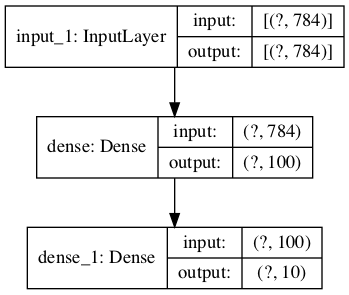

In [24]:
best_model = grid_cv.best_estimator_.model
keras.utils.plot_model(best_model, show_shapes=True)

In [25]:
best_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 38us/sample - loss: 0.1579 - accuracy: 0.9538


[0.1579398089684546, 0.9538]

## Further explortion...

Try the following grid parameters:

```python
param_grid = {'n_neurons': range(100,900,100)}
param_grid
```

Were you able to get accuracies over 99 percent? How many epochs are needed to train the model before it starts overfitting?

## Saving the best model

**N.B**: Note that I ran the code three times with a different numbr of nodes each and time with higher test accuracy (~99.6%). 

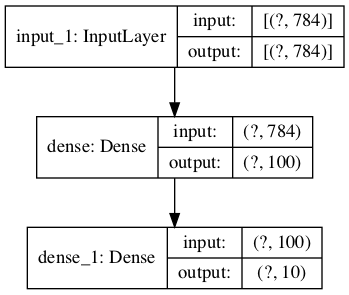

In [26]:
best_model = grid_cv.best_estimator_.model
keras.utils.plot_model(best_model, show_shapes=True)

In [27]:
best_model.save("mnist_model_best.h5")

## Evaluating the model

The model with 500 neurons gets a test accuracy of 98%

In [28]:
best_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 26us/sample - loss: 0.1579 - accuracy: 0.9538


[0.1579398089684546, 0.9538]

## Confusion matrix

Let us see what the confusion matrix looks like. Using both `sklearn.metrics` and `tensorflow`. Then we visualize the confusion matrix and see what that tells us.

In [29]:
# Get the predicted classes:
pred_classes = best_model.predict_classes(train_images)

In [30]:
from sklearn.metrics import confusion_matrix

conf_max = confusion_matrix(train_labels,pred_classes)
conf_max

array([[5349,    1,    3,    4,   12,   13,   13,    2,   44,    3],
       [   1, 6052,   18,   14,    8,   10,    2,   10,   51,   13],
       [  28,   22, 5057,   75,   40,   12,   28,   72,  125,   11],
       [  14,   16,   45, 5262,    5,   79,    5,   29,  146,   37],
       [   9,   12,   13,    2, 5088,    9,   25,    5,   35,  109],
       [  32,   13,    6,   63,   13, 4754,   16,    6,   58,   26],
       [  46,   16,    4,    3,   33,  102, 5172,    4,   37,    0],
       [   7,   21,   20,   30,   36,   12,    2, 5488,   21,   78],
       [  14,   31,    9,   36,   12,   34,    9,    5, 5206,   33],
       [  22,    8,    0,   49,   96,   25,    1,   67,   50, 5136]])

In [31]:
row_sums = conf_max.sum(axis=1, keepdims=True)
norm_conf_max = conf_max / row_sums

Looks like there were 38 threes confused as eights. You can see this in the heat map for the error below. 

## Visualizing the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

In [32]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

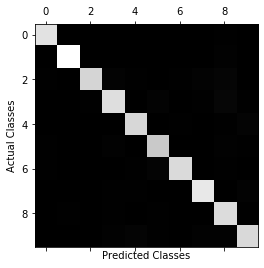

In [33]:
import matplotlib.pyplot as plt

plt.matshow(conf_max, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
# plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [34]:
row_sums = conf_max.sum(axis=1, keepdims=True)
norm_conf_max = conf_max / row_sums

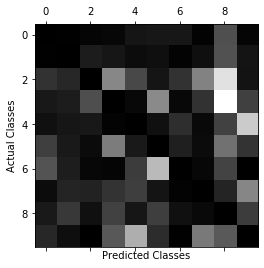

In [35]:
import matplotlib.pyplot as plt
np.fill_diagonal(norm_conf_max, 0)
plt.matshow(norm_conf_max, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
# plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

In [36]:
def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

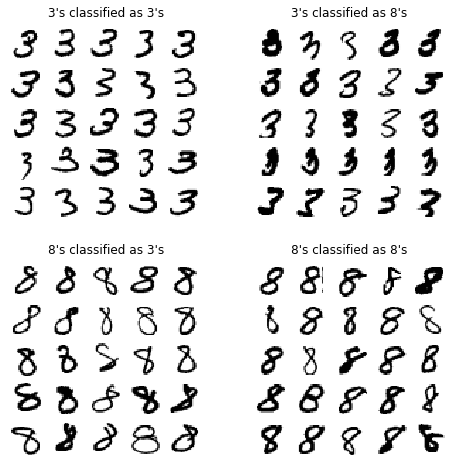

In [37]:
cl_a, cl_b = 3,8
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

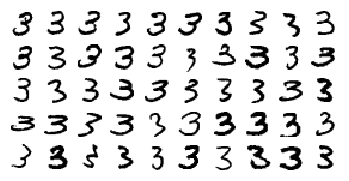

In [38]:
# display 50 of the 3's classified correctly
plot_digits(X_aa[:50],plt,images_per_row = 10)

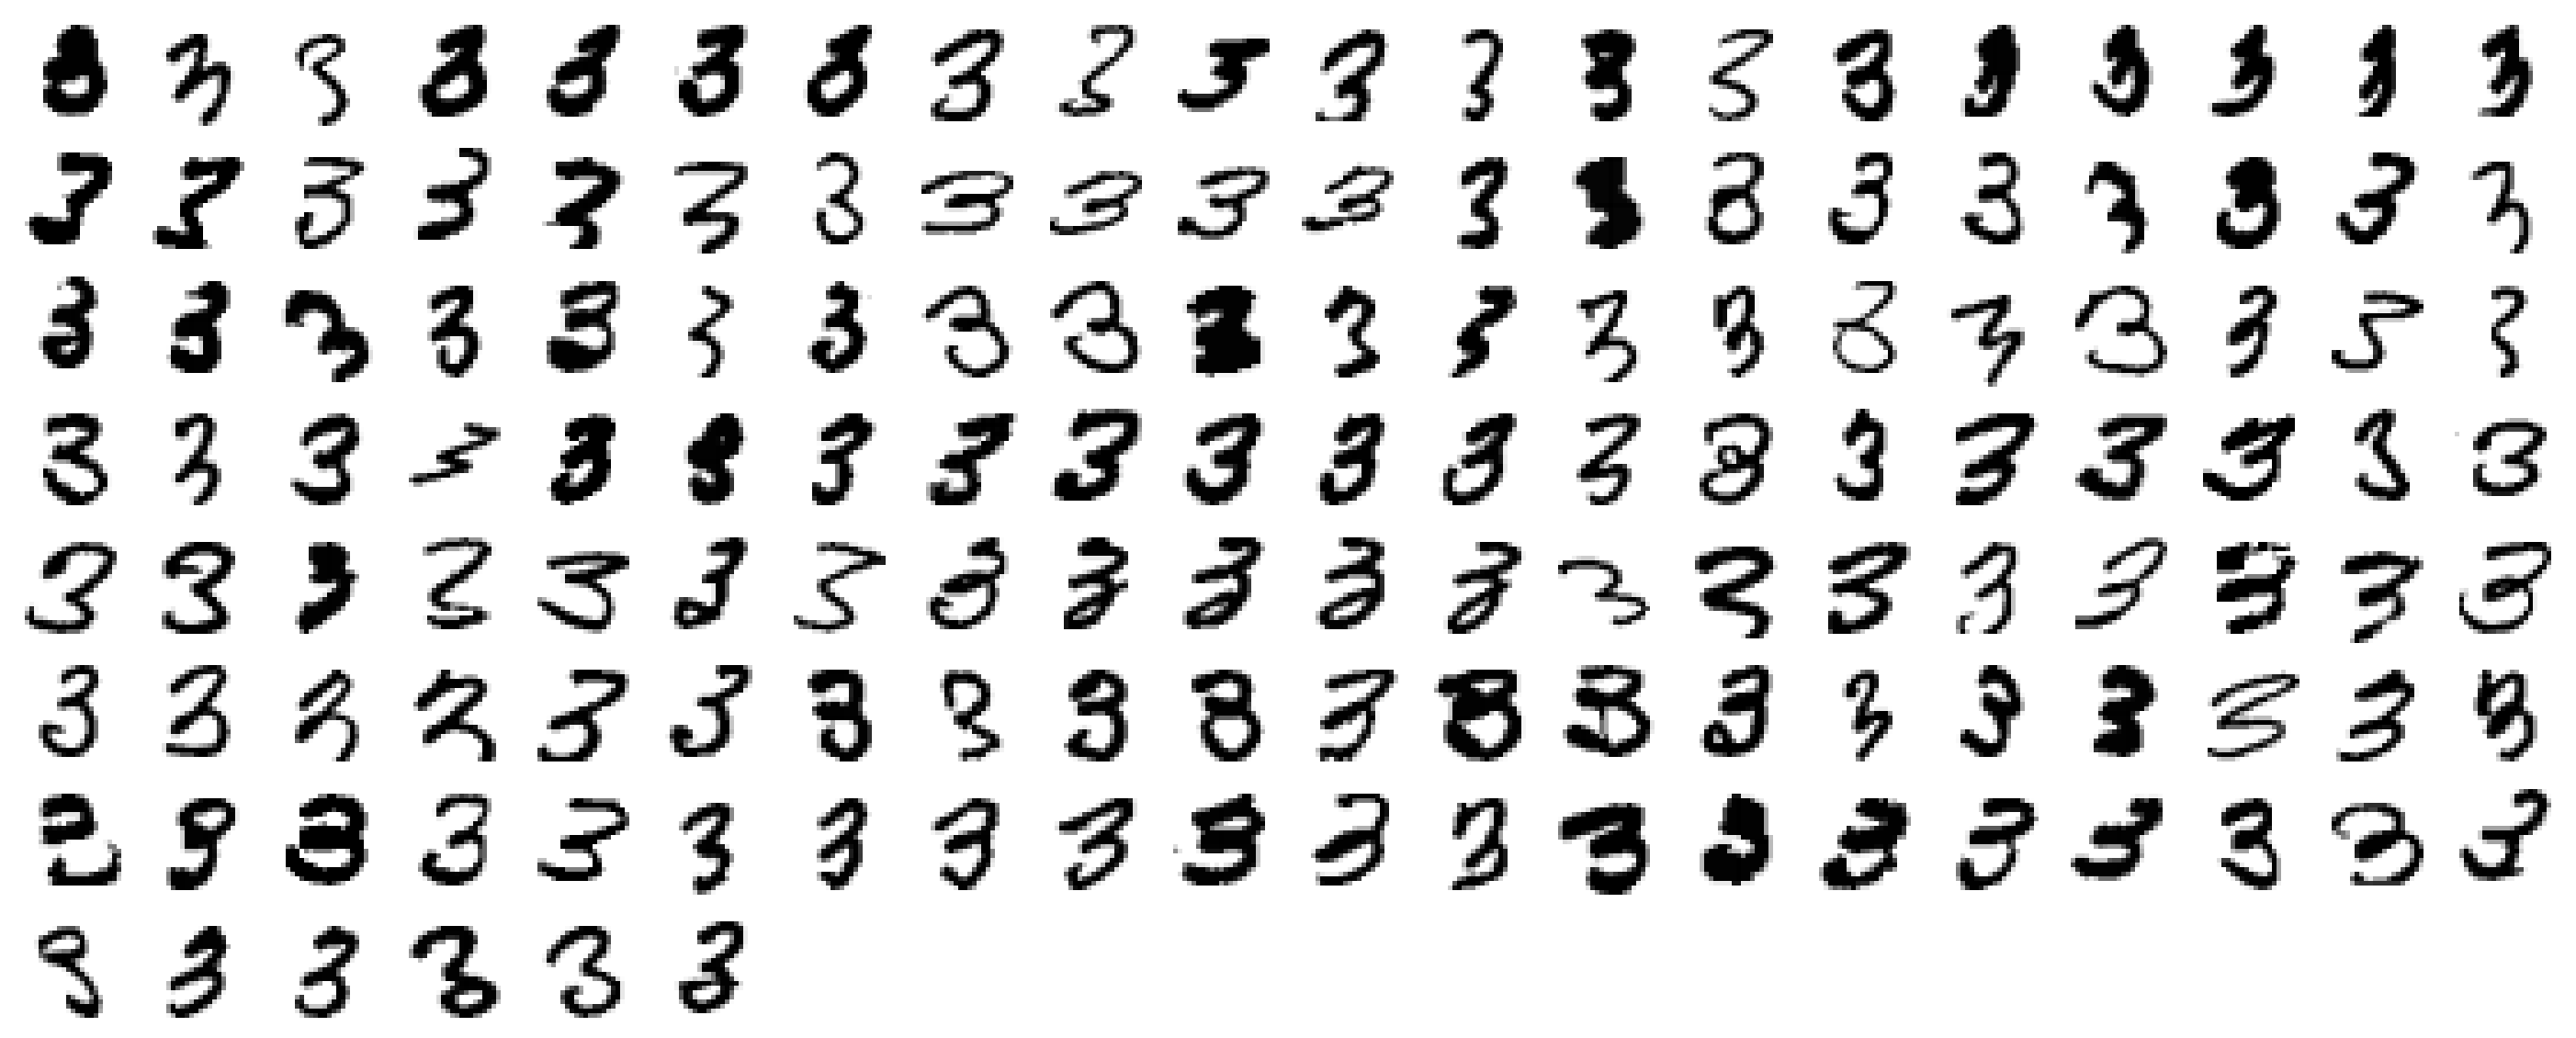

In [39]:
# display all the 3's classified as 8's
num = X_ab.shape[0]
plt.figure(figsize=(50,50))
plot_digits(X_ab[:num],plt, images_per_row = 20)

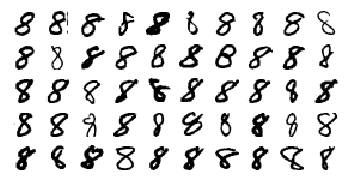

In [40]:
# display 50 of the 8's classified correctly
plot_digits(X_bb[:50],plt, images_per_row = 10)

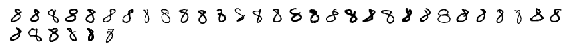

In [41]:
# display all the 8's classified as 3's
num = X_ba.shape[0]
plt.figure(figsize=(10,10))
plot_digits(X_ba[:num],plt, images_per_row = 30)

## Two hidden layer grid search

This part is working for `GridSearchCV` (but extremely slow) but not working for `EvolutionaryAlgorithmSearchCV`. It seems to hang...

This approach works for regular grid search

In [42]:
test_model=build_model2(n_neurons=(2,3))

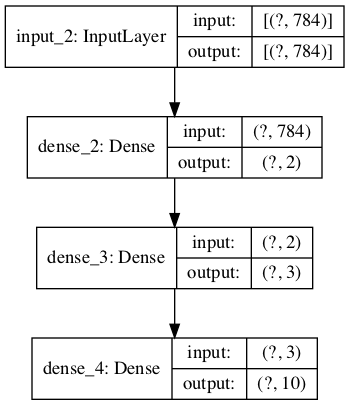

In [43]:
keras.utils.plot_model(test_model, show_shapes=True)

In [44]:
keras_clf2 = KerasClassifier(build_model2)

In [45]:
from itertools import combinations_with_replacement 
lst  = [(t[1],t[0]) for t in combinations_with_replacement([1,2], 3)] # first layer has less neurons than second
param_grid2 = {'n_neurons': lst}
param_grid2

{'n_neurons': [(1, 1), (1, 1), (2, 1), (2, 2)]}

Using ordinary grid search on a very small search space (which still takes 5 minutes to search...)

In [46]:
from sklearn.model_selection import GridSearchCV

grid_cv2 = GridSearchCV(estimator=keras_clf2, param_grid=param_grid2,cv=3,verbose = 2)

start_time = time.time()
grid_cv2.fit(train_images, train_labels, epochs=30,
                  validation_data=(val_images, val_labels),
                  callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neurons=(1, 1) ................................................
Train on 36666 samples, validate on 5000 samples
Epoch 1/30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


36666/36666 [==============================] - 2s 46us/sample - loss: 2.3018 - accuracy: 0.1105 - val_loss: 2.3008 - val_accuracy: 0.1126
Epoch 2/30
36666/36666 [==============================] - 1s 36us/sample - loss: 2.3016 - accuracy: 0.1114 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 3/30
18334/18334 [==============================] - 0s 22us/sample - loss: 2.3011 - accuracy: 0.1142
[CV] ................................. n_neurons=(1, 1), total=   5.0s
[CV] n_neurons=(1, 1) ................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


36667/36667 [==============================] - 2s 44us/sample - loss: 2.3017 - accuracy: 0.1110 - val_loss: 2.3012 - val_accuracy: 0.1126
Epoch 2/30
36667/36667 [==============================] - 1s 34us/sample - loss: 2.3014 - accuracy: 0.1113 - val_loss: 2.3010 - val_accuracy: 0.1126
Epoch 3/30
36667/36667 [==============================] - 2s 41us/sample - loss: 2.3013 - accuracy: 0.1113 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 4/30
36667/36667 [==============================] - 1s 39us/sample - loss: 2.3013 - accuracy: 0.1113 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 5/30
18333/18333 [==============================] - 0s 23us/sample - loss: 2.3014 - accuracy: 0.1144
[CV] ................................. n_neurons=(1, 1), total=   7.8s
[CV] n_neurons=(1, 1) ................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 50us/sample - loss: 1.9805 - accuracy: 0.2184 - val_loss

36667/36667 [==============================] - 1s 38us/sample - loss: 1.5882 - accuracy: 0.3851 - val_loss: 1.6013 - val_accuracy: 0.3882
Epoch 23/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.5848 - accuracy: 0.3871 - val_loss: 1.5987 - val_accuracy: 0.3970
Epoch 24/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.5823 - accuracy: 0.3865 - val_loss: 1.6032 - val_accuracy: 0.3852ss: 1.5855 - ac - ETA: 0s - loss: 1.5848 - accu
Epoch 25/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.5793 - accuracy: 0.3852 - val_loss: 1.5934 - val_accuracy: 0.3906
Epoch 26/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.5761 - accuracy: 0.3895 - val_loss: 1.5901 - val_accuracy: 0.3926
Epoch 27/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.5732 - accuracy: 0.3880 - val_loss: 1.5845 - val_accuracy: 0.3920
Epoch 28/30
36667/36667 [==============================] - 1s 37u

Epoch 18/30
36667/36667 [==============================] - 1s 35us/sample - loss: 1.5705 - accuracy: 0.4004 - val_loss: 1.5675 - val_accuracy: 0.4148
Epoch 19/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.5628 - accuracy: 0.4034 - val_loss: 1.5623 - val_accuracy: 0.4314
Epoch 20/30
36667/36667 [==============================] - 1s 33us/sample - loss: 1.5552 - accuracy: 0.4161 - val_loss: 1.5579 - val_accuracy: 0.4336
Epoch 21/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.5507 - accuracy: 0.4227 - val_loss: 1.5545 - val_accuracy: 0.4330
Epoch 22/30
36667/36667 [==============================] - 1s 35us/sample - loss: 1.5458 - accuracy: 0.4280 - val_loss: 1.5492 - val_accuracy: 0.4334
Epoch 23/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.5397 - accuracy: 0.4271 - val_loss: 1.5501 - val_accuracy: 0.4442
Epoch 24/30
36667/36667 [==============================] - 1s 35us/sample - loss: 1.5359 - accuracy:

Epoch 29/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.9620 - accuracy: 0.6642 - val_loss: 0.9540 - val_accuracy: 0.6646
Epoch 30/30
18333/18333 [==============================] - 0s 24us/sample - loss: 0.9959 - accuracy: 0.6547
[CV] ................................. n_neurons=(2, 2), total=  39.4s
[CV] n_neurons=(2, 2) ................................................
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 42us/sample - loss: 1.9021 - accuracy: 0.2841 - val_loss: 1.6322 - val_accuracy: 0.4032
Epoch 2/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.4654 - accuracy: 0.4488 - val_loss: 1.3405 - val_accuracy: 0.4902
Epoch 3/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.3089 - accuracy: 0.5007 - val_loss: 1.2539 - val_accuracy: 0.5198
Epoch 4/30
36667/36667 [==============================] - 1s 35us/sample - loss: 1.2475 - accuracy: 0.51

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.9min finished


55000/55000 [==============================] - 2s 38us/sample - loss: 1.7711 - accuracy: 0.3132 - val_loss: 1.4318 - val_accuracy: 0.4484
Epoch 2/30
55000/55000 [==============================] - 2s 35us/sample - loss: 1.3260 - accuracy: 0.5079 - val_loss: 1.2280 - val_accuracy: 0.5522
Epoch 3/30
55000/55000 [==============================] - 2s 33us/sample - loss: 1.1892 - accuracy: 0.5828 - val_loss: 1.1328 - val_accuracy: 0.6156
Epoch 4/30
55000/55000 [==============================] - 2s 33us/sample - loss: 1.1206 - accuracy: 0.6123 - val_loss: 1.0745 - val_accuracy: 0.6590
Epoch 5/30
55000/55000 [==============================] - 2s 33us/sample - loss: 1.0660 - accuracy: 0.6568 - val_loss: 1.0381 - val_accuracy: 0.6794
Epoch 6/30
55000/55000 [==============================] - 2s 33us/sample - loss: 1.0355 - accuracy: 0.6687 - val_loss: 1.0140 - val_accuracy: 0.6948
Epoch 7/30
55000/55000 [==============================] - 2s 34us/sample - loss: 1.0188 - accuracy: 0.6738 - val_loss

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1a4e9bd6d0>,
             iid='deprecated', n_jobs=None,
             param_grid={'n_neurons': [(1, 1), (1, 1), (2, 1), (2, 2)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [47]:
print(f"--- {round((time.time() - start_time)/60,2)} minutes ---")

--- 4.57 minutes ---


In [48]:
grid_cv2.best_params_ # parameters of best model obtain from GridSearchCV

{'n_neurons': (2, 2)}

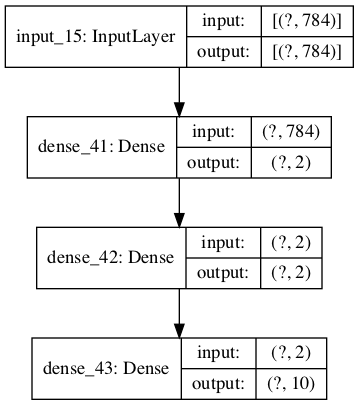

In [49]:
# display best model
best_model = grid_cv2.best_estimator_.model
keras.utils.plot_model(best_model, show_shapes=True)

Now let's try it with EvolutionaryAlgorithmSearchCV. Should take much less than 5 minutes--if only it didn't hang! 

In [50]:
keras_clf2 = KerasClassifier(build_model2) # get a fresh model to train

In [51]:
grid_cv2 = EvolutionaryAlgorithmSearchCV(estimator=keras_clf2,
                                   params=param_grid2,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)

/Users/EdwardArroyo/anaconda3/envs/laptop_env/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/EdwardArroyo/anaconda3/envs/laptop_env/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [52]:
# # Getting stuck for some reason
# grid_cv2.fit(train_images, train_labels)

Change of plan...Try it with our original build function...

```python
keras_clf3 = KerasClassifier(build_model)
param_grid3 = {'n_hidden': range(1,5),'n_neurons': range(1,5)}
```

Also get stuck!

In [55]:
param_grid3 = {'n_hidden': range(1,10),'n_neurons': range(1,10)}
param_grid3

{'n_hidden': range(1, 10), 'n_neurons': range(1, 10)}

In [56]:
keras_clf3 = KerasClassifier(build_model) # get a fresh model to train

In [57]:
grid_cv3 = EvolutionaryAlgorithmSearchCV(estimator=keras_clf3,
                                   params=param_grid3,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=2,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)

In [58]:
# # Getting stuck for some reason
# grid_cv3.fit(train_images, train_labels)

Let's try the same thing with GridSearchCV...

In [59]:
keras_clf3 = KerasClassifier(build_model) # get a fresh model to train

In [60]:
from sklearn.model_selection import GridSearchCV

grid_cv3 = GridSearchCV(estimator=keras_clf3, param_grid=param_grid3,cv=3,verbose = 0)

start_time = time.time()
grid_cv3.fit(train_images, train_labels, epochs=30,
                  validation_data=(val_images, val_labels),
                  callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 50us/sample - loss: 2.0080 - accuracy: 0.2130 - val_loss: 1.8678 - val_accuracy: 0.2396
Epoch 2/30
36666/36666 [==============================] - 1s 39us/sample - loss: 1.8102 - accuracy: 0.2573 - val_loss: 1.7450 - val_accuracy: 0.2816
Epoch 3/30
36666/36666 [==============================] - 1s 40us/sample - loss: 1.7255 - accuracy: 0.2903 - val_loss: 1.6918 - val_accuracy: 0.3126
Epoch 4/30
36666/36666 [==============================] - 1s 38us/sample - loss: 1.6802 - accuracy: 0.3109 - val_loss: 1.6549 - val_accuracy: 0.3362
Epoch 5/30
36666/36666 [==============================] - 2s 41us/sample - loss: 1.6544 - accuracy: 0.3246 - val_loss: 1.6339 - val_accuracy: 0.3364
Epoch 6/30
36666/36666 [==============================] - 1s 38us/sample - loss: 1.6379 - accuracy: 0.3333 - val_loss: 1.6206 - val_accuracy: 0.3476
Epoch 7/30
36666/36666 [==============================] -

18333/18333 [==============================] - 0s 21us/sample - loss: 1.5488 - accuracy: 0.3849
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 1s 41us/sample - loss: 2.0565 - accuracy: 0.1876 - val_loss: 1.8902 - val_accuracy: 0.2084
Epoch 2/30
36667/36667 [==============================] - 1s 32us/sample - loss: 1.8568 - accuracy: 0.2292 - val_loss: 1.7950 - val_accuracy: 0.2600
Epoch 3/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.7895 - accuracy: 0.2709 - val_loss: 1.7502 - val_accuracy: 0.2898
Epoch 4/30
36667/36667 [==============================] - 1s 32us/sample - loss: 1.7532 - accuracy: 0.2920 - val_loss: 1.7206 - val_accuracy: 0.3034
Epoch 5/30
36667/36667 [==============================] - 1s 32us/sample - loss: 1.7273 - accuracy: 0.3072 - val_loss: 1.7031 - val_accuracy: 0.3216
Epoch 6/30
36667/36667 [==============================] - 1s 32us/sample - loss: 1.7039 - accuracy: 0.3273 - v

Epoch 8/30
36667/36667 [==============================] - 1s 33us/sample - loss: 1.1091 - accuracy: 0.6405 - val_loss: 1.0888 - val_accuracy: 0.6532
Epoch 9/30
36667/36667 [==============================] - 1s 36us/sample - loss: 1.0935 - accuracy: 0.6454 - val_loss: 1.0849 - val_accuracy: 0.6584
Epoch 10/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.0814 - accuracy: 0.6503 - val_loss: 1.0658 - val_accuracy: 0.6608
Epoch 11/30
36667/36667 [==============================] - 1s 36us/sample - loss: 1.0723 - accuracy: 0.6542 - val_loss: 1.0572 - val_accuracy: 0.6646
Epoch 12/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.0644 - accuracy: 0.6551 - val_loss: 1.0556 - val_accuracy: 0.6580
Epoch 13/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.0582 - accuracy: 0.6584 - val_loss: 1.0476 - val_accuracy: 0.6660
Epoch 14/30
36667/36667 [==============================] - 1s 34us/sample - loss: 1.0524 - accuracy: 0

Epoch 11/30
36666/36666 [==============================] - 1s 34us/sample - loss: 0.7570 - accuracy: 0.7761 - val_loss: 0.7286 - val_accuracy: 0.7996
Epoch 12/30
36666/36666 [==============================] - 1s 36us/sample - loss: 0.7471 - accuracy: 0.7807 - val_loss: 0.7217 - val_accuracy: 0.7996
Epoch 13/30
36666/36666 [==============================] - 1s 34us/sample - loss: 0.7395 - accuracy: 0.7839 - val_loss: 0.7105 - val_accuracy: 0.7998
Epoch 14/30
36666/36666 [==============================] - 1s 34us/sample - loss: 0.7317 - accuracy: 0.7848 - val_loss: 0.7054 - val_accuracy: 0.8014
Epoch 15/30
36666/36666 [==============================] - 1s 34us/sample - loss: 0.7259 - accuracy: 0.7883 - val_loss: 0.7014 - val_accuracy: 0.8044
Epoch 16/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.7191 - accuracy: 0.7889 - val_loss: 0.6961 - val_accuracy: 0.8078
Epoch 17/30
36666/36666 [==============================] - 2s 41us/sample - loss: 0.7147 - accuracy:

36667/36667 [==============================] - 2s 43us/sample - loss: 0.7168 - accuracy: 0.7667 - val_loss: 0.6850 - val_accuracy: 0.7920
Epoch 8/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.7072 - accuracy: 0.7729 - val_loss: 0.6769 - val_accuracy: 0.7916
Epoch 9/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.6992 - accuracy: 0.7757 - val_loss: 0.6714 - val_accuracy: 0.7942
Epoch 10/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.6929 - accuracy: 0.7791 - val_loss: 0.6624 - val_accuracy: 0.8002
Epoch 11/30
36667/36667 [==============================] - 2s 61us/sample - loss: 0.6873 - accuracy: 0.7826 - val_loss: 0.6562 - val_accuracy: 0.8032
Epoch 12/30
36667/36667 [==============================] - 2s 55us/sample - loss: 0.6830 - accuracy: 0.7839 - val_loss: 0.6549 - val_accuracy: 0.8036
Epoch 13/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.6787 - accuracy: 0.7871 - val_

Epoch 19/30
36667/36667 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.86 - 1s 39us/sample - loss: 0.4818 - accuracy: 0.8632 - val_loss: 0.5030 - val_accuracy: 0.8622
Epoch 20/30
18333/18333 [==============================] - 0s 21us/sample - loss: 0.5349 - accuracy: 0.8507
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 51us/sample - loss: 1.3368 - accuracy: 0.5710 - val_loss: 0.8586 - val_accuracy: 0.7426
Epoch 2/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.7560 - accuracy: 0.7779 - val_loss: 0.6668 - val_accuracy: 0.8072
Epoch 3/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6643 - accuracy: 0.8063 - val_loss: 0.6230 - val_accuracy: 0.8162
Epoch 4/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6315 - accuracy: 0.8173 - val_loss: 0.6062 - val_accuracy: 0.8196
Epoch 5/30
36667/36667 [==============================]

36667/36667 [==============================] - 1s 34us/sample - loss: 0.4211 - accuracy: 0.8820 - val_loss: 0.4022 - val_accuracy: 0.8882
Epoch 7/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.4114 - accuracy: 0.8854 - val_loss: 0.3921 - val_accuracy: 0.8962
Epoch 8/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.4039 - accuracy: 0.8874 - val_loss: 0.3945 - val_accuracy: 0.8958
Epoch 9/30
18333/18333 [==============================] - 0s 23us/sample - loss: 0.4437 - accuracy: 0.8780
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 42us/sample - loss: 1.1211 - accuracy: 0.6566 - val_loss: 0.7613 - val_accuracy: 0.7840
Epoch 2/30
36667/36667 [==============================] - 1s 33us/sample - loss: 0.7184 - accuracy: 0.7896 - val_loss: 0.6365 - val_accuracy: 0.8242
Epoch 3/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.6221 - accuracy: 0.8224 - v

Epoch 8/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.3365 - accuracy: 0.9056 - val_loss: 0.3446 - val_accuracy: 0.9044
Epoch 9/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.3302 - accuracy: 0.9071 - val_loss: 0.3384 - val_accuracy: 0.9076
Epoch 10/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.3247 - accuracy: 0.9100 - val_loss: 0.3345 - val_accuracy: 0.9070
Epoch 11/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.3213 - accuracy: 0.9110 - val_loss: 0.3302 - val_accuracy: 0.9086
Epoch 12/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.3164 - accuracy: 0.9127 - val_loss: 0.3376 - val_accuracy: 0.9074
Epoch 13/30
18333/18333 [==============================] - 0s 21us/sample - loss: 0.3715 - accuracy: 0.8984
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.8756 - accur

Epoch 7/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.3509 - accuracy: 0.9013 - val_loss: 0.3229 - val_accuracy: 0.9046
Epoch 8/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.3459 - accuracy: 0.9021 - val_loss: 0.3265 - val_accuracy: 0.9078
Epoch 9/30
18333/18333 [==============================] - 0s 27us/sample - loss: 0.3426 - accuracy: 0.9020
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.6868 - accuracy: 0.7974 - val_loss: 0.3598 - val_accuracy: 0.9034
Epoch 2/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.3489 - accuracy: 0.9002 - val_loss: 0.3111 - val_accuracy: 0.9116
Epoch 3/30
36666/36666 [==============================] - 1s 35us/sample - loss: 0.3149 - accuracy: 0.9091 - val_loss: 0.2899 - val_accuracy: 0.9166
Epoch 4/30
36666/36666 [==============================] - 1s 35us/sample - loss: 0.2987 - accuracy:

36667/36667 [==============================] - 2s 43us/sample - loss: 0.2766 - accuracy: 0.9239 - val_loss: 0.2827 - val_accuracy: 0.9224
Epoch 7/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2704 - accuracy: 0.9271 - val_loss: 0.2804 - val_accuracy: 0.9220
Epoch 8/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.2655 - accuracy: 0.9285 - val_loss: 0.2878 - val_accuracy: 0.9214
Epoch 9/30
18333/18333 [==============================] - 0s 26us/sample - loss: 0.3075 - accuracy: 0.9168
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.7080 - accuracy: 0.7977 - val_loss: 0.3761 - val_accuracy: 0.8962
Epoch 2/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.3611 - accuracy: 0.8975 - val_loss: 0.3087 - val_accuracy: 0.9140
Epoch 3/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.3181 - accuracy: 0.9099 - v

18333/18333 [==============================] - 0s 22us/sample - loss: 2.3014 - accuracy: 0.1144
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 48us/sample - loss: 1.6685 - accuracy: 0.3950 - val_loss: 1.3928 - val_accuracy: 0.5320
Epoch 2/30
36667/36667 [==============================] - 2s 42us/sample - loss: 1.3043 - accuracy: 0.5563 - val_loss: 1.2157 - val_accuracy: 0.6054
Epoch 3/30
36667/36667 [==============================] - 1s 35us/sample - loss: 1.2004 - accuracy: 0.5891 - val_loss: 1.1550 - val_accuracy: 0.6118
Epoch 4/30
36667/36667 [==============================] - 1s 36us/sample - loss: 1.1595 - accuracy: 0.5985 - val_loss: 1.1229 - val_accuracy: 0.6230
Epoch 5/30
36667/36667 [==============================] - 1s 38us/sample - loss: 1.1359 - accuracy: 0.6097 - val_loss: 1.1020 - val_accuracy: 0.6260
Epoch 6/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.1172 - accuracy: 0.6207 - v

Epoch 9/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.8271 - accuracy: 0.7482 - val_loss: 0.8332 - val_accuracy: 0.7552
Epoch 10/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.8138 - accuracy: 0.7511 - val_loss: 0.8192 - val_accuracy: 0.7638
Epoch 11/30
36667/36667 [==============================] - 1s 34us/sample - loss: 0.8027 - accuracy: 0.7567 - val_loss: 0.8114 - val_accuracy: 0.7602
Epoch 12/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.7918 - accuracy: 0.7593 - val_loss: 0.8063 - val_accuracy: 0.7656
Epoch 13/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.7835 - accuracy: 0.7605 - val_loss: 0.7884 - val_accuracy: 0.7656
Epoch 14/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.7717 - accuracy: 0.7635 - val_loss: 0.7791 - val_accuracy: 0.7684
Epoch 15/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.7598 - accuracy: 

Epoch 4/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.6872 - accuracy: 0.8094 - val_loss: 0.6287 - val_accuracy: 0.8208
Epoch 5/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6269 - accuracy: 0.8243 - val_loss: 0.5720 - val_accuracy: 0.8434
Epoch 6/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.5942 - accuracy: 0.8327 - val_loss: 0.5601 - val_accuracy: 0.8476
Epoch 7/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.5734 - accuracy: 0.8387 - val_loss: 0.5394 - val_accuracy: 0.8532
Epoch 8/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.5593 - accuracy: 0.8420 - val_loss: 0.5375 - val_accuracy: 0.8558
Epoch 9/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.5472 - accuracy: 0.8461 - val_loss: 0.5345 - val_accuracy: 0.8562
Epoch 10/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.5381 - accuracy: 0.850

Epoch 2/30
36666/36666 [==============================] - 1s 36us/sample - loss: 1.0874 - accuracy: 0.6173 - val_loss: 0.9603 - val_accuracy: 0.6754
Epoch 3/30
36666/36666 [==============================] - 1s 35us/sample - loss: 0.8852 - accuracy: 0.7171 - val_loss: 0.8055 - val_accuracy: 0.7586
Epoch 4/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.7643 - accuracy: 0.7640 - val_loss: 0.7244 - val_accuracy: 0.7806
Epoch 5/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.6996 - accuracy: 0.7795 - val_loss: 0.6738 - val_accuracy: 0.7960
Epoch 6/30
36666/36666 [==============================] - 1s 39us/sample - loss: 0.6590 - accuracy: 0.7964 - val_loss: 0.6375 - val_accuracy: 0.8126
Epoch 7/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.6280 - accuracy: 0.8091 - val_loss: 0.6068 - val_accuracy: 0.8270
Epoch 8/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.5999 - accuracy: 0.8210

Epoch 8/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.5867 - accuracy: 0.8358 - val_loss: 0.5775 - val_accuracy: 0.8392
Epoch 9/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.5744 - accuracy: 0.8385 - val_loss: 0.5679 - val_accuracy: 0.8390
Epoch 10/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.5633 - accuracy: 0.8427 - val_loss: 0.5546 - val_accuracy: 0.8450
Epoch 11/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.5549 - accuracy: 0.8451 - val_loss: 0.5479 - val_accuracy: 0.8466
Epoch 12/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.5470 - accuracy: 0.8473 - val_loss: 0.5444 - val_accuracy: 0.8532
Epoch 13/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.5400 - accuracy: 0.8493 - val_loss: 0.5361 - val_accuracy: 0.8530
Epoch 14/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.5330 - accuracy: 0

Epoch 14/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3375 - accuracy: 0.9030 - val_loss: 0.3495 - val_accuracy: 0.9050
Epoch 15/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.3324 - accuracy: 0.9054 - val_loss: 0.3483 - val_accuracy: 0.9034
Epoch 16/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.3303 - accuracy: 0.9065 - val_loss: 0.3456 - val_accuracy: 0.9028
Epoch 17/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.3247 - accuracy: 0.9081 - val_loss: 0.3458 - val_accuracy: 0.9074
Epoch 18/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.3211 - accuracy: 0.9088 - val_loss: 0.3403 - val_accuracy: 0.9062ccuracy: 0.90
Epoch 19/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.3188 - accuracy: 0.9108 - val_loss: 0.3392 - val_accuracy: 0.9060
Epoch 20/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.316

Epoch 4/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3809 - accuracy: 0.8916 - val_loss: 0.3461 - val_accuracy: 0.9066
Epoch 5/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.3596 - accuracy: 0.8970 - val_loss: 0.3293 - val_accuracy: 0.9108
Epoch 6/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.3435 - accuracy: 0.9014 - val_loss: 0.3506 - val_accuracy: 0.8960: 0.3400 - accura
Epoch 7/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.3303 - accuracy: 0.9056 - val_loss: 0.3029 - val_accuracy: 0.9132
Epoch 8/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3184 - accuracy: 0.9086 - val_loss: 0.2990 - val_accuracy: 0.9178
Epoch 9/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.3098 - accuracy: 0.9111 - val_loss: 0.2977 - val_accuracy: 0.9142
Epoch 10/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.3040 

36666/36666 [==============================] - 1s 37us/sample - loss: 0.3191 - accuracy: 0.9100 - val_loss: 0.2951 - val_accuracy: 0.9196
Epoch 4/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.2972 - accuracy: 0.9153 - val_loss: 0.2849 - val_accuracy: 0.9204
Epoch 5/30
36666/36666 [==============================] - 1s 39us/sample - loss: 0.2818 - accuracy: 0.9204 - val_loss: 0.2831 - val_accuracy: 0.9206
Epoch 6/30
36666/36666 [==============================] - 2s 43us/sample - loss: 0.2705 - accuracy: 0.9231 - val_loss: 0.2633 - val_accuracy: 0.9268
Epoch 7/30
36666/36666 [==============================] - 1s 41us/sample - loss: 0.2618 - accuracy: 0.9259 - val_loss: 0.2683 - val_accuracy: 0.9260
Epoch 8/30
36666/36666 [==============================] - 1s 36us/sample - loss: 0.2531 - accuracy: 0.9281 - val_loss: 0.2563 - val_accuracy: 0.9308
Epoch 9/30
36666/36666 [==============================] - 1s 36us/sample - loss: 0.2457 - accuracy: 0.9297 - val_loss

36666/36666 [==============================] - 1s 37us/sample - loss: 1.5241 - accuracy: 0.3796 - val_loss: 1.5439 - val_accuracy: 0.3734
Epoch 18/30
36666/36666 [==============================] - 1s 37us/sample - loss: 1.5216 - accuracy: 0.3807 - val_loss: 1.5278 - val_accuracy: 0.4114
Epoch 19/30
36666/36666 [==============================] - 1s 38us/sample - loss: 1.5189 - accuracy: 0.3853 - val_loss: 1.5241 - val_accuracy: 0.3888
Epoch 20/30
36666/36666 [==============================] - 1s 36us/sample - loss: 1.5172 - accuracy: 0.3836 - val_loss: 1.5209 - val_accuracy: 0.3950
Epoch 21/30
36666/36666 [==============================] - 1s 38us/sample - loss: 1.5150 - accuracy: 0.3865 - val_loss: 1.5196 - val_accuracy: 0.4008
Epoch 22/30
36666/36666 [==============================] - 2s 41us/sample - loss: 1.5133 - accuracy: 0.3874 - val_loss: 1.5179 - val_accuracy: 0.4030
Epoch 23/30
36666/36666 [==============================] - 3s 94us/sample - loss: 1.5126 - accuracy: 0.3893 - va

36667/36667 [==============================] - 1s 36us/sample - loss: 1.8783 - accuracy: 0.2380 - val_loss: 1.7938 - val_accuracy: 0.2438
Epoch 3/30
36667/36667 [==============================] - 1s 40us/sample - loss: 1.7613 - accuracy: 0.2851 - val_loss: 1.6811 - val_accuracy: 0.3192
Epoch 4/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.6617 - accuracy: 0.3266 - val_loss: 1.6051 - val_accuracy: 0.3526
Epoch 5/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.6038 - accuracy: 0.3569 - val_loss: 1.5661 - val_accuracy: 0.3730
Epoch 6/30
36667/36667 [==============================] - 1s 40us/sample - loss: 1.5701 - accuracy: 0.3607 - val_loss: 1.5354 - val_accuracy: 0.3796
Epoch 7/30
36667/36667 [==============================] - 2s 46us/sample - loss: 1.5487 - accuracy: 0.3634 - val_loss: 1.5190 - val_accuracy: 0.3676s - loss: 1.5629 -  - ETA: 1s - loss: - ETA: 0s - loss: 1.5489 - accura
Epoch 8/30
36667/36667 [======================

36667/36667 [==============================] - 1s 38us/sample - loss: 1.1154 - accuracy: 0.5742 - val_loss: 1.1199 - val_accuracy: 0.5852
Epoch 11/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.1046 - accuracy: 0.5793 - val_loss: 1.1057 - val_accuracy: 0.5908
Epoch 12/30
36667/36667 [==============================] - 1s 38us/sample - loss: 1.0940 - accuracy: 0.5850 - val_loss: 1.1045 - val_accuracy: 0.5978
Epoch 13/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.0873 - accuracy: 0.5910 - val_loss: 1.0906 - val_accuracy: 0.6132
Epoch 14/30
36667/36667 [==============================] - 1s 38us/sample - loss: 1.0796 - accuracy: 0.5986 - val_loss: 1.0834 - val_accuracy: 0.6162
Epoch 15/30
36667/36667 [==============================] - 1s 40us/sample - loss: 1.0737 - accuracy: 0.6089 - val_loss: 1.0750 - val_accuracy: 0.6208
Epoch 16/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.0675 - accuracy: 0.6152 - va

Epoch 11/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.8722 - accuracy: 0.7447 - val_loss: 0.8749 - val_accuracy: 0.7596
Epoch 12/30
36666/36666 [==============================] - 1s 36us/sample - loss: 0.8592 - accuracy: 0.7476 - val_loss: 0.8626 - val_accuracy: 0.7572
Epoch 13/30
36666/36666 [==============================] - 1s 41us/sample - loss: 0.8494 - accuracy: 0.7526 - val_loss: 0.8543 - val_accuracy: 0.7676
Epoch 14/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.8272 - accuracy: 0.7660 - val_loss: 0.8154 - val_accuracy: 0.7772
Epoch 15/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.7745 - accuracy: 0.7867 - val_loss: 0.7681 - val_accuracy: 0.7968
Epoch 16/30
36666/36666 [==============================] - 1s 39us/sample - loss: 0.7419 - accuracy: 0.7954 - val_loss: 0.7459 - val_accuracy: 0.8048
Epoch 17/30
36666/36666 [==============================] - 1s 39us/sample - loss: 0.7177 - accuracy:

Epoch 9/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.6483 - accuracy: 0.8100 - val_loss: 0.6234 - val_accuracy: 0.8210
Epoch 10/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.6344 - accuracy: 0.8164 - val_loss: 0.6103 - val_accuracy: 0.8324
Epoch 11/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.6242 - accuracy: 0.8198 - val_loss: 0.5987 - val_accuracy: 0.8346
Epoch 12/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.6158 - accuracy: 0.8230 - val_loss: 0.5952 - val_accuracy: 0.8360
Epoch 13/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.6100 - accuracy: 0.8252 - val_loss: 0.5897 - val_accuracy: 0.8338
Epoch 14/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.6047 - accuracy: 0.8271 - val_loss: 0.5808 - val_accuracy: 0.8400
Epoch 15/30
36667/36667 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.82 - 

36667/36667 [==============================] - 1s 37us/sample - loss: 0.6116 - accuracy: 0.8271 - val_loss: 0.6064 - val_accuracy: 0.8270
Epoch 17/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.6011 - accuracy: 0.8314 - val_loss: 0.5825 - val_accuracy: 0.8382
Epoch 18/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.5946 - accuracy: 0.8319 - val_loss: 0.5836 - val_accuracy: 0.8400
Epoch 19/30
18333/18333 [==============================] - 0s 24us/sample - loss: 0.6097 - accuracy: 0.8289
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 51us/sample - loss: 1.3867 - accuracy: 0.5633 - val_loss: 0.9517 - val_accuracy: 0.7670
Epoch 2/30
36666/36666 [==============================] - 2s 66us/sample - loss: 0.8340 - accuracy: 0.7861 - val_loss: 0.7282 - val_accuracy: 0.8178
Epoch 3/30
36666/36666 [==============================] - 1s 38us/sample - loss: 0.6908 - accuracy: 0.8134 

36666/36666 [==============================] - 1s 41us/sample - loss: 0.3994 - accuracy: 0.8856 - val_loss: 0.3961 - val_accuracy: 0.8914
Epoch 6/30
36666/36666 [==============================] - 1s 40us/sample - loss: 0.3787 - accuracy: 0.8929 - val_loss: 0.3754 - val_accuracy: 0.8992
Epoch 7/30
36666/36666 [==============================] - 1s 39us/sample - loss: 0.3627 - accuracy: 0.8987 - val_loss: 0.3602 - val_accuracy: 0.9006
Epoch 8/30
36666/36666 [==============================] - 1s 38us/sample - loss: 0.3498 - accuracy: 0.9025 - val_loss: 0.3525 - val_accuracy: 0.9014
Epoch 9/30
36666/36666 [==============================] - 1s 39us/sample - loss: 0.3399 - accuracy: 0.9051 - val_loss: 0.3610 - val_accuracy: 0.8966
Epoch 10/30
36666/36666 [==============================] - 2s 46us/sample - loss: 0.3316 - accuracy: 0.9076 - val_loss: 0.3385 - val_accuracy: 0.9044
Epoch 11/30
36666/36666 [==============================] - 2s 42us/sample - loss: 0.3258 - accuracy: 0.9092 - val_lo

36667/36667 [==============================] - 1s 37us/sample - loss: 0.2712 - accuracy: 0.9253 - val_loss: 0.3064 - val_accuracy: 0.9218
Epoch 14/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.2664 - accuracy: 0.9266 - val_loss: 0.3064 - val_accuracy: 0.9194
Epoch 15/30
18333/18333 [==============================] - 0s 23us/sample - loss: 0.3278 - accuracy: 0.9114
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.9440 - accuracy: 0.7144 - val_loss: 0.5524 - val_accuracy: 0.8472
Epoch 2/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4997 - accuracy: 0.8618 - val_loss: 0.4317 - val_accuracy: 0.8768
Epoch 3/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4089 - accuracy: 0.8828 - val_loss: 0.3555 - val_accuracy: 0.9008
Epoch 4/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.3655 - accuracy: 0.8968 -

Epoch 12/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.2588 - accuracy: 0.9258 - val_loss: 0.2575 - val_accuracy: 0.9284
Epoch 13/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.2542 - accuracy: 0.9286 - val_loss: 0.2737 - val_accuracy: 0.9226
Epoch 14/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.2498 - accuracy: 0.9287 - val_loss: 0.2543 - val_accuracy: 0.9260
Epoch 15/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.2465 - accuracy: 0.9294 - val_loss: 0.2609 - val_accuracy: 0.9268
Epoch 16/30
18333/18333 [==============================] - 0s 24us/sample - loss: 0.2812 - accuracy: 0.9222
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 52us/sample - loss: 2.3018 - accuracy: 0.1105 - val_loss: 2.3008 - val_accuracy: 0.1126
Epoch 2/30
36666/36666 [==============================] - 1s 38us/sample - loss: 2.3016 - accu

18333/18333 [==============================] - 0s 25us/sample - loss: 1.4635 - accuracy: 0.4048s - loss: 1.4682 - accuracy: 0.
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 58us/sample - loss: 2.3015 - accuracy: 0.1138 - val_loss: 2.3007 - val_accuracy: 0.1126
Epoch 2/30
36667/36667 [==============================] - 2s 44us/sample - loss: 2.3012 - accuracy: 0.1143 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 3/30
18333/18333 [==============================] - 0s 24us/sample - loss: 2.3018 - accuracy: 0.1085
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 52us/sample - loss: 1.7020 - accuracy: 0.3672 - val_loss: 1.3594 - val_accuracy: 0.4648
Epoch 2/30
36666/36666 [==============================] - 1s 41us/sample - loss: 1.2308 - accuracy: 0.5500 - val_loss: 1.1276 - val_accuracy: 0.5974
Epoch 3/30
36666/36666 [==============================] - 1s 41us/sample

18333/18333 [==============================] - 0s 24us/sample - loss: 1.0153 - accuracy: 0.6637
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 50us/sample - loss: 1.9559 - accuracy: 0.2470 - val_loss: 1.6159 - val_accuracy: 0.4074
Epoch 2/30
36667/36667 [==============================] - 2s 43us/sample - loss: 1.4801 - accuracy: 0.4380 - val_loss: 1.3285 - val_accuracy: 0.5026
Epoch 3/30
36667/36667 [==============================] - 2s 47us/sample - loss: 1.3058 - accuracy: 0.5202 - val_loss: 1.2208 - val_accuracy: 0.5666
Epoch 4/30
36667/36667 [==============================] - 2s 43us/sample - loss: 1.2058 - accuracy: 0.5736 - val_loss: 1.1342 - val_accuracy: 0.6008
Epoch 5/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.1289 - accuracy: 0.6023 - val_loss: 1.0666 - val_accuracy: 0.6324
Epoch 6/30
36667/36667 [==============================] - 1s 38us/sample - loss: 1.0677 - accuracy: 0.6324 - v

Epoch 12/30
36667/36667 [==============================] - 2s 49us/sample - loss: 1.3980 - accuracy: 0.4749 - val_loss: 1.4256 - val_accuracy: 0.4590
Epoch 13/30
36667/36667 [==============================] - 3s 88us/sample - loss: 1.3854 - accuracy: 0.4779 - val_loss: 1.3987 - val_accuracy: 0.4796
Epoch 14/30
36667/36667 [==============================] - 2s 41us/sample - loss: 1.3738 - accuracy: 0.4831 - val_loss: 1.3801 - val_accuracy: 0.4726
Epoch 15/30
36667/36667 [==============================] - 1s 40us/sample - loss: 1.3650 - accuracy: 0.4842 - val_loss: 1.3858 - val_accuracy: 0.4824
Epoch 16/30
18333/18333 [==============================] - 0s 23us/sample - loss: 1.4116 - accuracy: 0.4696
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 51us/sample - loss: 1.7832 - accuracy: 0.3121 - val_loss: 1.3092 - val_accuracy: 0.4984
Epoch 2/30
36667/36667 [==============================] - 2s 42us/sample - loss: 1.1460 - accu

18334/18334 [==============================] - 0s 25us/sample - loss: 0.6168 - accuracy: 0.8261
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 53us/sample - loss: 1.5184 - accuracy: 0.4808 - val_loss: 1.0391 - val_accuracy: 0.6944
Epoch 2/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.9059 - accuracy: 0.7323 - val_loss: 0.7707 - val_accuracy: 0.7776
Epoch 3/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.7256 - accuracy: 0.7876 - val_loss: 0.6619 - val_accuracy: 0.8174
Epoch 4/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6505 - accuracy: 0.8131 - val_loss: 0.6397 - val_accuracy: 0.8252
Epoch 5/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.6130 - accuracy: 0.8273 - val_loss: 0.5943 - val_accuracy: 0.8440
Epoch 6/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.5911 - accuracy: 0.8344 - v

18334/18334 [==============================] - 0s 26us/sample - loss: 0.4235 - accuracy: 0.8886
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 52us/sample - loss: 1.1952 - accuracy: 0.5850 - val_loss: 0.8019 - val_accuracy: 0.7538
Epoch 2/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.7121 - accuracy: 0.7891 - val_loss: 0.6130 - val_accuracy: 0.8322
Epoch 3/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.5880 - accuracy: 0.8321 - val_loss: 0.5365 - val_accuracy: 0.8588
Epoch 4/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.5176 - accuracy: 0.8562 - val_loss: 0.5065 - val_accuracy: 0.8592
Epoch 5/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4802 - accuracy: 0.8689 - val_loss: 0.4695 - val_accuracy: 0.8732
Epoch 6/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4548 - accuracy: 0.8751 - v

Epoch 2/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6168 - accuracy: 0.8087 - val_loss: 0.5297 - val_accuracy: 0.8382
Epoch 3/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.4984 - accuracy: 0.8452 - val_loss: 0.4834 - val_accuracy: 0.8632
Epoch 4/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.4505 - accuracy: 0.8643 - val_loss: 0.4415 - val_accuracy: 0.8748
Epoch 5/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.4246 - accuracy: 0.8724 - val_loss: 0.4137 - val_accuracy: 0.8856
Epoch 6/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4037 - accuracy: 0.8818 - val_loss: 0.3948 - val_accuracy: 0.8900
Epoch 7/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.3881 - accuracy: 0.8864 - val_loss: 0.3854 - val_accuracy: 0.8936
Epoch 8/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.3741 - accuracy: 0.8922

36667/36667 [==============================] - 2s 42us/sample - loss: 0.3063 - accuracy: 0.9095 - val_loss: 0.3123 - val_accuracy: 0.9146
Epoch 9/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.2974 - accuracy: 0.9122 - val_loss: 0.3031 - val_accuracy: 0.9124
Epoch 10/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.2922 - accuracy: 0.9143 - val_loss: 0.2992 - val_accuracy: 0.9146
Epoch 11/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.2846 - accuracy: 0.9165 - val_loss: 0.3012 - val_accuracy: 0.9130
Epoch 12/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.2785 - accuracy: 0.9189 - val_loss: 0.2989 - val_accuracy: 0.9150
Epoch 13/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2734 - accuracy: 0.9196 - val_loss: 0.3013 - val_accuracy: 0.9096
Epoch 14/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.2688 - accuracy: 0.9215 - val

Epoch 14/30
18333/18333 [==============================] - 0s 24us/sample - loss: 0.2886 - accuracy: 0.9190
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 55us/sample - loss: 2.3018 - accuracy: 0.1105 - val_loss: 2.3008 - val_accuracy: 0.1126
Epoch 2/30
36666/36666 [==============================] - 2s 50us/sample - loss: 2.3016 - accuracy: 0.1114 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 3/30
18334/18334 [==============================] - 1s 28us/sample - loss: 2.3011 - accuracy: 0.1142
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 54us/sample - loss: 2.3017 - accuracy: 0.1110 - val_loss: 2.3012 - val_accuracy: 0.1126
Epoch 2/30
36667/36667 [==============================] - 1s 36us/sample - loss: 2.3014 - accuracy: 0.1113 - val_loss: 2.3010 - val_accuracy: 0.1126
Epoch 3/30
36667/36667 [==============================] - 1s 40us/sample - loss: 2.3013 - a

36667/36667 [==============================] - 1s 40us/sample - loss: 1.6823 - accuracy: 0.3367 - val_loss: 1.6129 - val_accuracy: 0.3654
Epoch 4/30
36667/36667 [==============================] - 1s 41us/sample - loss: 1.5896 - accuracy: 0.3610 - val_loss: 1.5352 - val_accuracy: 0.3776
Epoch 5/30
36667/36667 [==============================] - 1s 40us/sample - loss: 1.5294 - accuracy: 0.3751 - val_loss: 1.4884 - val_accuracy: 0.3870
Epoch 6/30
36667/36667 [==============================] - 1s 38us/sample - loss: 1.4931 - accuracy: 0.3851 - val_loss: 1.4682 - val_accuracy: 0.4000
Epoch 7/30
36667/36667 [==============================] - 1s 40us/sample - loss: 1.4680 - accuracy: 0.3945 - val_loss: 1.4457 - val_accuracy: 0.3998
Epoch 8/30
36667/36667 [==============================] - 1s 40us/sample - loss: 1.4521 - accuracy: 0.4017 - val_loss: 1.4353 - val_accuracy: 0.4064
Epoch 9/30
36667/36667 [==============================] - 1s 38us/sample - loss: 1.4340 - accuracy: 0.4097 - val_loss

Epoch 12/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.9342 - accuracy: 0.7115 - val_loss: 0.9394 - val_accuracy: 0.7212
Epoch 13/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.9276 - accuracy: 0.7183 - val_loss: 0.9308 - val_accuracy: 0.7268
Epoch 14/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.9201 - accuracy: 0.7215 - val_loss: 0.9350 - val_accuracy: 0.7228
Epoch 15/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.9144 - accuracy: 0.7247 - val_loss: 0.9246 - val_accuracy: 0.7222
Epoch 16/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.9095 - accuracy: 0.7281 - val_loss: 0.9451 - val_accuracy: 0.7216
Epoch 17/30
18333/18333 [==============================] - 0s 24us/sample - loss: 0.9686 - accuracy: 0.7106
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 53us/sample - loss: 1.9896 - acc

Epoch 4/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.8371 - accuracy: 0.7358 - val_loss: 0.7985 - val_accuracy: 0.7534
Epoch 5/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.7945 - accuracy: 0.7550 - val_loss: 0.7600 - val_accuracy: 0.7796
Epoch 6/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.7616 - accuracy: 0.7737 - val_loss: 0.7414 - val_accuracy: 0.7890
Epoch 7/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.7344 - accuracy: 0.7920 - val_loss: 0.7094 - val_accuracy: 0.8068
Epoch 8/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.7122 - accuracy: 0.8000 - val_loss: 0.6886 - val_accuracy: 0.8100
Epoch 9/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.6952 - accuracy: 0.8057 - val_loss: 0.6720 - val_accuracy: 0.8202
Epoch 10/30
36667/36667 [==============================] - 1s 35us/sample - loss: 0.6822 - accuracy: 0.808

36667/36667 [==============================] - 1s 41us/sample - loss: 0.5046 - accuracy: 0.8634 - val_loss: 0.5317 - val_accuracy: 0.8568
Epoch 21/30
36667/36667 [==============================] - 1s 41us/sample - loss: 0.4999 - accuracy: 0.8627 - val_loss: 0.5293 - val_accuracy: 0.8592
Epoch 22/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.4956 - accuracy: 0.8642 - val_loss: 0.5223 - val_accuracy: 0.8590
Epoch 23/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.4933 - accuracy: 0.8657 - val_loss: 0.5246 - val_accuracy: 0.8628
Epoch 24/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.4906 - accuracy: 0.8673 - val_loss: 0.5090 - val_accuracy: 0.8652
Epoch 25/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.4868 - accuracy: 0.8672 - val_loss: 0.5171 - val_accuracy: 0.8590
Epoch 26/30
18333/18333 [==============================] - 0s 25us/sample - loss: 0.5348 - accuracy: 0.8522
Trai

Epoch 6/30
36667/36667 [==============================] - 2s 51us/sample - loss: 0.5203 - accuracy: 0.8453 - val_loss: 0.5029 - val_accuracy: 0.8606
Epoch 7/30
36667/36667 [==============================] - 2s 60us/sample - loss: 0.5023 - accuracy: 0.8499 - val_loss: 0.4831 - val_accuracy: 0.8632
Epoch 8/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4853 - accuracy: 0.8530 - val_loss: 0.4929 - val_accuracy: 0.8584
Epoch 9/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4777 - accuracy: 0.8580 - val_loss: 0.4681 - val_accuracy: 0.8644
Epoch 10/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.4681 - accuracy: 0.8603 - val_loss: 0.4568 - val_accuracy: 0.8704
Epoch 11/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4628 - accuracy: 0.8627 - val_loss: 0.4528 - val_accuracy: 0.8746
Epoch 12/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4574 - accuracy: 0.8

Epoch 21/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.4646 - accuracy: 0.8701 - val_loss: 0.4983 - val_accuracy: 0.8636
Epoch 22/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.4573 - accuracy: 0.8739 - val_loss: 0.4847 - val_accuracy: 0.8722
Epoch 23/30
36667/36667 [==============================] - 2s 56us/sample - loss: 0.4450 - accuracy: 0.8762 - val_loss: 0.4921 - val_accuracy: 0.8720
Epoch 24/30
36667/36667 [==============================] - 2s 61us/sample - loss: 0.4340 - accuracy: 0.8780 - val_loss: 0.4711 - val_accuracy: 0.8780
Epoch 25/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4240 - accuracy: 0.8804 - val_loss: 0.4714 - val_accuracy: 0.8756
Epoch 26/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.4142 - accuracy: 0.8829 - val_loss: 0.4583 - val_accuracy: 0.8812
Epoch 27/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4040 - accuracy:

Epoch 13/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.2920 - accuracy: 0.9178 - val_loss: 0.3478 - val_accuracy: 0.9084
Epoch 14/30
36667/36667 [==============================] - 1s 36us/sample - loss: 0.2863 - accuracy: 0.9206 - val_loss: 0.3137 - val_accuracy: 0.9168
Epoch 15/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.2811 - accuracy: 0.9210 - val_loss: 0.3175 - val_accuracy: 0.9182
Epoch 16/30
18333/18333 [==============================] - 0s 24us/sample - loss: 0.3412 - accuracy: 0.9084
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 52us/sample - loss: 1.2987 - accuracy: 0.5265 - val_loss: 0.7820 - val_accuracy: 0.7238
Epoch 2/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.6738 - accuracy: 0.7943 - val_loss: 0.5574 - val_accuracy: 0.8468
Epoch 3/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.5404 - accur

Epoch 12/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2396 - accuracy: 0.9312 - val_loss: 0.2524 - val_accuracy: 0.9282
Epoch 13/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2339 - accuracy: 0.9332 - val_loss: 0.2486 - val_accuracy: 0.9270
Epoch 14/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2309 - accuracy: 0.9344 - val_loss: 0.2605 - val_accuracy: 0.9288
Epoch 15/30
18333/18333 [==============================] - 0s 24us/sample - loss: 0.2891 - accuracy: 0.9207
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 50us/sample - loss: 1.1114 - accuracy: 0.6443 - val_loss: 0.6825 - val_accuracy: 0.8108
Epoch 2/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.6098 - accuracy: 0.8229 - val_loss: 0.4675 - val_accuracy: 0.8654
Epoch 3/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4619 - accur

Epoch 6/30
36666/36666 [==============================] - 1s 37us/sample - loss: 1.0553 - accuracy: 0.6012 - val_loss: 1.0547 - val_accuracy: 0.6054
Epoch 7/30
36666/36666 [==============================] - 1s 37us/sample - loss: 1.0285 - accuracy: 0.6132 - val_loss: 1.0328 - val_accuracy: 0.6120
Epoch 8/30
36666/36666 [==============================] - 1s 39us/sample - loss: 1.0079 - accuracy: 0.6238 - val_loss: 1.0126 - val_accuracy: 0.6212
Epoch 9/30
36666/36666 [==============================] - 1s 38us/sample - loss: 0.9872 - accuracy: 0.6304 - val_loss: 0.9888 - val_accuracy: 0.6412
Epoch 10/30
36666/36666 [==============================] - 1s 38us/sample - loss: 0.9690 - accuracy: 0.6352 - val_loss: 0.9656 - val_accuracy: 0.6446
Epoch 11/30
36666/36666 [==============================] - 1s 37us/sample - loss: 0.9501 - accuracy: 0.6420 - val_loss: 0.9514 - val_accuracy: 0.6508
Epoch 12/30
36666/36666 [==============================] - 1s 40us/sample - loss: 0.9353 - accuracy: 0.6

Epoch 4/30
36667/36667 [==============================] - 1s 39us/sample - loss: 2.3013 - accuracy: 0.1113 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 5/30
18333/18333 [==============================] - 0s 23us/sample - loss: 2.3014 - accuracy: 0.1144
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 60us/sample - loss: 1.8367 - accuracy: 0.3124 - val_loss: 1.5955 - val_accuracy: 0.4220
Epoch 2/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.4481 - accuracy: 0.4645 - val_loss: 1.3310 - val_accuracy: 0.4856
Epoch 3/30
36667/36667 [==============================] - 1s 37us/sample - loss: 1.2719 - accuracy: 0.5310 - val_loss: 1.1690 - val_accuracy: 0.6228
Epoch 4/30
36667/36667 [==============================] - 1s 40us/sample - loss: 1.1034 - accuracy: 0.6771 - val_loss: 0.9817 - val_accuracy: 0.7602
Epoch 5/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.9495 - accuracy:

Epoch 4/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.9367 - accuracy: 0.6861 - val_loss: 0.8688 - val_accuracy: 0.7324
Epoch 5/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.8533 - accuracy: 0.7375 - val_loss: 0.8055 - val_accuracy: 0.7672
Epoch 6/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.7866 - accuracy: 0.7608 - val_loss: 0.7546 - val_accuracy: 0.7676
Epoch 7/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.7465 - accuracy: 0.7740 - val_loss: 0.7395 - val_accuracy: 0.7826
Epoch 8/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.7130 - accuracy: 0.7859 - val_loss: 0.6893 - val_accuracy: 0.8040
Epoch 9/30
36667/36667 [==============================] - 2s 51us/sample - loss: 0.6875 - accuracy: 0.7945 - val_loss: 0.6760 - val_accuracy: 0.7980
Epoch 10/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.6692 - accuracy: 0.799

Epoch 18/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.6510 - accuracy: 0.8215 - val_loss: 0.6603 - val_accuracy: 0.8194
Epoch 19/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.6440 - accuracy: 0.8228 - val_loss: 0.6539 - val_accuracy: 0.8180
Epoch 20/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.6365 - accuracy: 0.8282 - val_loss: 0.6563 - val_accuracy: 0.8216
Epoch 21/30
18333/18333 [==============================] - 0s 25us/sample - loss: 0.7085 - accuracy: 0.8047
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 60us/sample - loss: 1.8641 - accuracy: 0.3029 - val_loss: 1.6196 - val_accuracy: 0.4244
Epoch 2/30
36667/36667 [==============================] - 2s 43us/sample - loss: 1.4325 - accuracy: 0.4952 - val_loss: 1.2975 - val_accuracy: 0.5356
Epoch 3/30
36667/36667 [==============================] - 2s 52us/sample - loss: 1.1916 - accur

Epoch 8/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.4446 - accuracy: 0.8773 - val_loss: 0.4534 - val_accuracy: 0.8906
Epoch 9/30
36667/36667 [==============================] - 1s 39us/sample - loss: 0.4270 - accuracy: 0.8825 - val_loss: 0.4583 - val_accuracy: 0.8852
Epoch 10/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.4144 - accuracy: 0.8883 - val_loss: 0.4227 - val_accuracy: 0.8912
Epoch 11/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.4043 - accuracy: 0.8920 - val_loss: 0.4208 - val_accuracy: 0.8970
Epoch 12/30
36667/36667 [==============================] - 1s 41us/sample - loss: 0.3953 - accuracy: 0.8942 - val_loss: 0.4163 - val_accuracy: 0.8964
Epoch 13/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3875 - accuracy: 0.8966 - val_loss: 0.4085 - val_accuracy: 0.9018
Epoch 14/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3827 - accuracy: 0

Epoch 5/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.4241 - accuracy: 0.8813 - val_loss: 0.3972 - val_accuracy: 0.8912
Epoch 6/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3969 - accuracy: 0.8896 - val_loss: 0.3802 - val_accuracy: 0.8988
Epoch 7/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.3771 - accuracy: 0.8937 - val_loss: 0.3625 - val_accuracy: 0.9074
Epoch 8/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.3642 - accuracy: 0.8975 - val_loss: 0.3528 - val_accuracy: 0.9084
Epoch 9/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3545 - accuracy: 0.9006 - val_loss: 0.3848 - val_accuracy: 0.8942
Epoch 10/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.3458 - accuracy: 0.9052 - val_loss: 0.3517 - val_accuracy: 0.9088
Epoch 11/30
36667/36667 [==============================] - 1s 40us/sample - loss: 0.3397 - accuracy: 0.90

Epoch 17/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2670 - accuracy: 0.9264 - val_loss: 0.3147 - val_accuracy: 0.9216
Epoch 18/30
36667/36667 [==============================] - 1s 37us/sample - loss: 0.2643 - accuracy: 0.9264 - val_loss: 0.3264 - val_accuracy: 0.9220
Epoch 19/30
18333/18333 [==============================] - 0s 24us/sample - loss: 0.3517 - accuracy: 0.9038
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 3s 71us/sample - loss: 1.1371 - accuracy: 0.6066 - val_loss: 0.6854 - val_accuracy: 0.7920
Epoch 2/30
36667/36667 [==============================] - 1s 38us/sample - loss: 0.5523 - accuracy: 0.8448 - val_loss: 0.4494 - val_accuracy: 0.8810
Epoch 3/30
36667/36667 [==============================] - 2s 41us/sample - loss: 0.4436 - accuracy: 0.8757 - val_loss: 0.3965 - val_accuracy: 0.8912
Epoch 4/30
36667/36667 [==============================] - 2s 63us/sample - loss: 0.3920 - accura

36667/36667 [==============================] - 1s 39us/sample - loss: 1.6641 - accuracy: 0.3470 - val_loss: 1.6443 - val_accuracy: 0.3656
Epoch 13/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.6561 - accuracy: 0.3536 - val_loss: 1.6421 - val_accuracy: 0.3706
Epoch 14/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.6490 - accuracy: 0.3599 - val_loss: 1.6331 - val_accuracy: 0.3778
Epoch 15/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.6416 - accuracy: 0.3659 - val_loss: 1.6333 - val_accuracy: 0.3776
Epoch 16/30
36667/36667 [==============================] - 1s 38us/sample - loss: 1.6337 - accuracy: 0.3727 - val_loss: 1.6163 - val_accuracy: 0.3900
Epoch 17/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.6244 - accuracy: 0.3803 - val_loss: 1.6084 - val_accuracy: 0.4022
Epoch 18/30
36667/36667 [==============================] - 1s 39us/sample - loss: 1.6154 - accuracy: 0.3853 - va

36667/36667 [==============================] - 2s 63us/sample - loss: 2.3015 - accuracy: 0.1132 - val_loss: 2.3007 - val_accuracy: 0.1126
Epoch 2/30
36667/36667 [==============================] - 2s 42us/sample - loss: 2.3012 - accuracy: 0.1143 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 3/30
18333/18333 [==============================] - 0s 25us/sample - loss: 2.3018 - accuracy: 0.1085
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 57us/sample - loss: 1.8135 - accuracy: 0.3110 - val_loss: 1.5109 - val_accuracy: 0.4206
Epoch 2/30
36666/36666 [==============================] - 1s 38us/sample - loss: 1.4340 - accuracy: 0.4630 - val_loss: 1.3744 - val_accuracy: 0.4668
Epoch 3/30
36666/36666 [==============================] - 1s 39us/sample - loss: 1.3155 - accuracy: 0.5028 - val_loss: 1.2644 - val_accuracy: 0.5370
Epoch 4/30
36666/36666 [==============================] - 1s 39us/sample - loss: 1.2211 - accuracy: 0.5644 - v

36666/36666 [==============================] - 2s 57us/sample - loss: 1.4555 - accuracy: 0.4831 - val_loss: 1.3616 - val_accuracy: 0.5958
Epoch 3/30
36666/36666 [==============================] - 2s 45us/sample - loss: 1.1607 - accuracy: 0.6466 - val_loss: 1.0619 - val_accuracy: 0.68141.1653 - accuracy: 0.
Epoch 4/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.9790 - accuracy: 0.6986 - val_loss: 0.9487 - val_accuracy: 0.7104
Epoch 5/30
36666/36666 [==============================] - 2s 52us/sample - loss: 0.9005 - accuracy: 0.7251 - val_loss: 0.8933 - val_accuracy: 0.7448
Epoch 6/30
36666/36666 [==============================] - 2s 46us/sample - loss: 0.8496 - accuracy: 0.7478 - val_loss: 0.8563 - val_accuracy: 0.7662
Epoch 7/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.8163 - accuracy: 0.7636 - val_loss: 0.8460 - val_accuracy: 0.7648
Epoch 8/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.7930 - accura

Epoch 3/30
36666/36666 [==============================] - 2s 48us/sample - loss: 1.2071 - accuracy: 0.5511 - val_loss: 1.0821 - val_accuracy: 0.6266
Epoch 4/30
36666/36666 [==============================] - 2s 45us/sample - loss: 1.0398 - accuracy: 0.6380 - val_loss: 1.0011 - val_accuracy: 0.6750
Epoch 5/30
36666/36666 [==============================] - 2s 47us/sample - loss: 0.9401 - accuracy: 0.6954 - val_loss: 0.8696 - val_accuracy: 0.7392
Epoch 6/30
36666/36666 [==============================] - 2s 48us/sample - loss: 0.8337 - accuracy: 0.7444 - val_loss: 0.7881 - val_accuracy: 0.7680
Epoch 7/30
36666/36666 [==============================] - 2s 47us/sample - loss: 0.7677 - accuracy: 0.7730 - val_loss: 0.7139 - val_accuracy: 0.8098
Epoch 8/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.7019 - accuracy: 0.8045 - val_loss: 0.6807 - val_accuracy: 0.8270
Epoch 9/30
36666/36666 [==============================] - 2s 55us/sample - loss: 0.6632 - accuracy: 0.8194

Epoch 13/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.5325 - accuracy: 0.8537 - val_loss: 0.5326 - val_accuracy: 0.8620
Epoch 14/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.5216 - accuracy: 0.8558 - val_loss: 0.5212 - val_accuracy: 0.8704
Epoch 15/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.5127 - accuracy: 0.8603 - val_loss: 0.5320 - val_accuracy: 0.8558
Epoch 16/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.5055 - accuracy: 0.8616 - val_loss: 0.5075 - val_accuracy: 0.8688
Epoch 17/30
36667/36667 [==============================] - 2s 52us/sample - loss: 0.4999 - accuracy: 0.8639 - val_loss: 0.5058 - val_accuracy: 0.8678
Epoch 18/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.4903 - accuracy: 0.8659 - val_loss: 0.4949 - val_accuracy: 0.8774
Epoch 19/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.4863 - accuracy:

36667/36667 [==============================] - 2s 49us/sample - loss: 0.3905 - accuracy: 0.8928 - val_loss: 0.4159 - val_accuracy: 0.8896
Epoch 20/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.3860 - accuracy: 0.8943 - val_loss: 0.4278 - val_accuracy: 0.8876
Epoch 21/30
18333/18333 [==============================] - 1s 29us/sample - loss: 0.4628 - accuracy: 0.8766
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 62us/sample - loss: 1.4622 - accuracy: 0.4874 - val_loss: 0.9916 - val_accuracy: 0.7114
Epoch 2/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.8335 - accuracy: 0.7688 - val_loss: 0.6906 - val_accuracy: 0.8190
Epoch 3/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.5854 - accuracy: 0.8475 - val_loss: 0.4999 - val_accuracy: 0.8760
Epoch 4/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.4624 - accuracy: 0.8763 -

36667/36667 [==============================] - 2s 44us/sample - loss: 0.4556 - accuracy: 0.8829 - val_loss: 0.4446 - val_accuracy: 0.8874
Epoch 10/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.4327 - accuracy: 0.8885 - val_loss: 0.4415 - val_accuracy: 0.8914
Epoch 11/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4146 - accuracy: 0.8944 - val_loss: 0.4224 - val_accuracy: 0.8894
Epoch 12/30
36667/36667 [==============================] - 3s 82us/sample - loss: 0.3999 - accuracy: 0.8972 - val_loss: 0.3866 - val_accuracy: 0.9018
Epoch 13/30
36667/36667 [==============================] - 2s 63us/sample - loss: 0.3885 - accuracy: 0.8985 - val_loss: 0.3886 - val_accuracy: 0.9032
Epoch 14/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.3781 - accuracy: 0.9011 - val_loss: 0.3820 - val_accuracy: 0.8982
Epoch 15/30
36667/36667 [==============================] - 2s 53us/sample - loss: 0.3680 - accuracy: 0.9029 - va

Epoch 18/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.2630 - accuracy: 0.9305 - val_loss: 0.2807 - val_accuracy: 0.9256
Epoch 19/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.2600 - accuracy: 0.9312 - val_loss: 0.2748 - val_accuracy: 0.9314
Epoch 20/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.2535 - accuracy: 0.9329 - val_loss: 0.2978 - val_accuracy: 0.9260
Epoch 21/30
36667/36667 [==============================] - 2s 56us/sample - loss: 0.2520 - accuracy: 0.9342 - val_loss: 0.2689 - val_accuracy: 0.9340
Epoch 22/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.2487 - accuracy: 0.9348 - val_loss: 0.2698 - val_accuracy: 0.9312
Epoch 23/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.2437 - accuracy: 0.9362 - val_loss: 0.2652 - val_accuracy: 0.9298
Epoch 24/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.2410 - accuracy:

Epoch 15/30
36667/36667 [==============================] - 2s 52us/sample - loss: 1.2734 - accuracy: 0.4913 - val_loss: 1.3248 - val_accuracy: 0.4962
Epoch 16/30
36667/36667 [==============================] - 2s 53us/sample - loss: 1.2590 - accuracy: 0.5057 - val_loss: 1.2908 - val_accuracy: 0.5168
Epoch 17/30
36667/36667 [==============================] - 2s 59us/sample - loss: 1.2476 - accuracy: 0.5199 - val_loss: 1.2896 - val_accuracy: 0.5168
Epoch 18/30
36667/36667 [==============================] - 2s 50us/sample - loss: 1.2340 - accuracy: 0.5244 - val_loss: 1.2757 - val_accuracy: 0.5328
Epoch 19/30
36667/36667 [==============================] - 2s 49us/sample - loss: 1.2192 - accuracy: 0.5360 - val_loss: 1.2553 - val_accuracy: 0.5428
Epoch 20/30
36667/36667 [==============================] - 2s 52us/sample - loss: 1.1980 - accuracy: 0.5515 - val_loss: 1.2394 - val_accuracy: 0.5492
Epoch 21/30
36667/36667 [==============================] - 2s 51us/sample - loss: 1.1652 - accuracy:

Epoch 8/30
36667/36667 [==============================] - 3s 71us/sample - loss: 0.9166 - accuracy: 0.6439 - val_loss: 0.9061 - val_accuracy: 0.6532
Epoch 9/30
36667/36667 [==============================] - 2s 53us/sample - loss: 0.8927 - accuracy: 0.6535 - val_loss: 0.9163 - val_accuracy: 0.6426
Epoch 10/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.8772 - accuracy: 0.6558 - val_loss: 0.8832 - val_accuracy: 0.6562
Epoch 11/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.8638 - accuracy: 0.6631 - val_loss: 0.8697 - val_accuracy: 0.6608
Epoch 12/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.8546 - accuracy: 0.6684 - val_loss: 0.8668 - val_accuracy: 0.6660
Epoch 13/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.8416 - accuracy: 0.7070 - val_loss: 0.8480 - val_accuracy: 0.7290
Epoch 14/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.7912 - accuracy: 0

Epoch 14/30
36666/36666 [==============================] - 2s 46us/sample - loss: 0.5303 - accuracy: 0.8621 - val_loss: 0.5869 - val_accuracy: 0.8550
Epoch 15/30
36666/36666 [==============================] - 2s 48us/sample - loss: 0.5243 - accuracy: 0.8648 - val_loss: 0.5640 - val_accuracy: 0.8676
Epoch 16/30
36666/36666 [==============================] - 2s 50us/sample - loss: 0.5155 - accuracy: 0.8651 - val_loss: 0.5650 - val_accuracy: 0.8632
Epoch 17/30
18334/18334 [==============================] - 1s 29us/sample - loss: 0.5760 - accuracy: 0.8545
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 68us/sample - loss: 1.6685 - accuracy: 0.3505 - val_loss: 1.3018 - val_accuracy: 0.4812
Epoch 2/30
36667/36667 [==============================] - 2s 50us/sample - loss: 1.1648 - accuracy: 0.5854 - val_loss: 0.9781 - val_accuracy: 0.7180
Epoch 3/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.9390 - accur

Epoch 11/30
36666/36666 [==============================] - 2s 42us/sample - loss: 0.4522 - accuracy: 0.8714 - val_loss: 0.4626 - val_accuracy: 0.8742
Epoch 12/30
36666/36666 [==============================] - 2s 52us/sample - loss: 0.4383 - accuracy: 0.8754 - val_loss: 0.4557 - val_accuracy: 0.8808
Epoch 13/30
36666/36666 [==============================] - 2s 48us/sample - loss: 0.4320 - accuracy: 0.8781 - val_loss: 0.4820 - val_accuracy: 0.8710
Epoch 14/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.4241 - accuracy: 0.8787 - val_loss: 0.4430 - val_accuracy: 0.8850
Epoch 15/30
36666/36666 [==============================] - 2s 47us/sample - loss: 0.4153 - accuracy: 0.8817 - val_loss: 0.4324 - val_accuracy: 0.8878
Epoch 16/30
36666/36666 [==============================] - 2s 49us/sample - loss: 0.4098 - accuracy: 0.8846 - val_loss: 0.4367 - val_accuracy: 0.8832
Epoch 17/30
36666/36666 [==============================] - 2s 48us/sample - loss: 0.4020 - accuracy:

Epoch 16/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.3240 - accuracy: 0.9137 - val_loss: 0.3570 - val_accuracy: 0.9122
Epoch 17/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.3206 - accuracy: 0.9157 - val_loss: 0.3576 - val_accuracy: 0.9084
Epoch 18/30
36666/36666 [==============================] - 1s 41us/sample - loss: 0.3152 - accuracy: 0.9167 - val_loss: 0.3547 - val_accuracy: 0.9068
Epoch 19/30
36666/36666 [==============================] - 2s 45us/sample - loss: 0.3113 - accuracy: 0.9180 - val_loss: 0.3744 - val_accuracy: 0.9052
Epoch 20/30
18334/18334 [==============================] - 0s 24us/sample - loss: 0.3758 - accuracy: 0.9033
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 4s 101us/sample - loss: 1.4691 - accuracy: 0.4459 - val_loss: 1.1036 - val_accuracy: 0.6508
Epoch 2/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.9319 - acc

36666/36666 [==============================] - 2s 60us/sample - loss: 1.4819 - accuracy: 0.4216 - val_loss: 1.0818 - val_accuracy: 0.6142
Epoch 2/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.9748 - accuracy: 0.6436 - val_loss: 0.8933 - val_accuracy: 0.6852
Epoch 3/30
36666/36666 [==============================] - 2s 43us/sample - loss: 0.7955 - accuracy: 0.7308 - val_loss: 0.6983 - val_accuracy: 0.7956
Epoch 4/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.6429 - accuracy: 0.8108 - val_loss: 0.5801 - val_accuracy: 0.8400
Epoch 5/30
36666/36666 [==============================] - 2s 44us/sample - loss: 0.5312 - accuracy: 0.8470 - val_loss: 0.4939 - val_accuracy: 0.8662
Epoch 6/30
36666/36666 [==============================] - 2s 46us/sample - loss: 0.4726 - accuracy: 0.8655 - val_loss: 0.4620 - val_accuracy: 0.8674
Epoch 7/30
36666/36666 [==============================] - 2s 43us/sample - loss: 0.4254 - accuracy: 0.8805 - val_loss

Epoch 20/30
18333/18333 [==============================] - 0s 25us/sample - loss: 0.3519 - accuracy: 0.9074
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 64us/sample - loss: 2.3018 - accuracy: 0.1105 - val_loss: 2.3008 - val_accuracy: 0.1126
Epoch 2/30
36666/36666 [==============================] - 2s 45us/sample - loss: 2.3016 - accuracy: 0.1114 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 3/30
18334/18334 [==============================] - 1s 30us/sample - loss: 2.3011 - accuracy: 0.1142
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 62us/sample - loss: 2.0843 - accuracy: 0.1959 - val_loss: 1.9505 - val_accuracy: 0.2396
Epoch 2/30
36667/36667 [==============================] - 2s 43us/sample - loss: 1.9001 - accuracy: 0.2704 - val_loss: 1.8304 - val_accuracy: 0.3008
Epoch 3/30
36667/36667 [==============================] - 2s 48us/sample - loss: 1.8188 - a

36666/36666 [==============================] - 2s 63us/sample - loss: 2.3018 - accuracy: 0.1105 - val_loss: 2.3008 - val_accuracy: 0.1126
Epoch 2/30
36666/36666 [==============================] - 2s 44us/sample - loss: 2.3016 - accuracy: 0.1114 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 3/30
18334/18334 [==============================] - 0s 26us/sample - loss: 2.3011 - accuracy: 0.1142
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 64us/sample - loss: 2.3017 - accuracy: 0.1109 - val_loss: 2.3012 - val_accuracy: 0.1126
Epoch 2/30
36667/36667 [==============================] - 2s 50us/sample - loss: 2.3014 - accuracy: 0.1113 - val_loss: 2.3010 - val_accuracy: 0.1126
Epoch 3/30
36667/36667 [==============================] - 2s 43us/sample - loss: 2.3013 - accuracy: 0.1113 - val_loss: 2.3009 - val_accuracy: 0.1126
Epoch 4/30
36667/36667 [==============================] - 2s 42us/sample - loss: 2.3013 - accuracy: 0.1113 - v

36667/36667 [==============================] - 2s 49us/sample - loss: 0.9570 - accuracy: 0.6430 - val_loss: 0.9117 - val_accuracy: 0.6634
Epoch 11/30
36667/36667 [==============================] - 2s 58us/sample - loss: 0.9380 - accuracy: 0.6476 - val_loss: 0.9171 - val_accuracy: 0.6630
Epoch 12/30
36667/36667 [==============================] - 2s 51us/sample - loss: 0.9253 - accuracy: 0.6534 - val_loss: 0.9058 - val_accuracy: 0.6624
Epoch 13/30
36667/36667 [==============================] - 2s 57us/sample - loss: 0.9161 - accuracy: 0.6544 - val_loss: 0.8968 - val_accuracy: 0.6696
Epoch 14/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.9057 - accuracy: 0.6538 - val_loss: 0.8799 - val_accuracy: 0.6742
Epoch 15/30
36667/36667 [==============================] - 2s 48us/sample - loss: 0.9004 - accuracy: 0.6583 - val_loss: 0.8851 - val_accuracy: 0.6766
Epoch 16/30
18333/18333 [==============================] - 0s 25us/sample - loss: 0.9116 - accuracy: 0.6667
Trai

Epoch 5/30
36667/36667 [==============================] - 2s 48us/sample - loss: 1.1887 - accuracy: 0.5260 - val_loss: 1.1145 - val_accuracy: 0.5630
Epoch 6/30
36667/36667 [==============================] - 2s 46us/sample - loss: 1.1082 - accuracy: 0.5757 - val_loss: 1.0541 - val_accuracy: 0.5996
Epoch 7/30
36667/36667 [==============================] - 2s 49us/sample - loss: 1.0332 - accuracy: 0.6061 - val_loss: 0.9930 - val_accuracy: 0.6118
Epoch 8/30
36667/36667 [==============================] - 2s 56us/sample - loss: 0.9830 - accuracy: 0.6276 - val_loss: 1.0395 - val_accuracy: 0.6088
Epoch 9/30
36667/36667 [==============================] - 2s 52us/sample - loss: 0.9447 - accuracy: 0.6387 - val_loss: 0.9091 - val_accuracy: 0.6472
Epoch 10/30
36667/36667 [==============================] - 2s 53us/sample - loss: 0.9143 - accuracy: 0.6492 - val_loss: 0.8867 - val_accuracy: 0.6562
Epoch 11/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.8896 - accuracy: 0.65

36667/36667 [==============================] - 3s 75us/sample - loss: 0.4399 - accuracy: 0.8862 - val_loss: 0.4587 - val_accuracy: 0.8802
Epoch 14/30
36667/36667 [==============================] - 2s 64us/sample - loss: 0.4308 - accuracy: 0.8865 - val_loss: 0.4603 - val_accuracy: 0.8882
Epoch 15/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.4184 - accuracy: 0.8901 - val_loss: 0.4530 - val_accuracy: 0.8894
Epoch 16/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4112 - accuracy: 0.8928 - val_loss: 0.4523 - val_accuracy: 0.8892
Epoch 17/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.4022 - accuracy: 0.8955 - val_loss: 0.4627 - val_accuracy: 0.8878
Epoch 18/30
36667/36667 [==============================] - 2s 52us/sample - loss: 0.3990 - accuracy: 0.8976 - val_loss: 0.4451 - val_accuracy: 0.8862
Epoch 19/30
36667/36667 [==============================] - 2s 51us/sample - loss: 0.3944 - accuracy: 0.8995 - va

Epoch 7/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.4783 - accuracy: 0.8690 - val_loss: 0.5441 - val_accuracy: 0.8544
Epoch 8/30
36667/36667 [==============================] - 2s 50us/sample - loss: 0.4554 - accuracy: 0.8769 - val_loss: 0.4450 - val_accuracy: 0.8876
Epoch 9/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4403 - accuracy: 0.8788 - val_loss: 0.4689 - val_accuracy: 0.8800
Epoch 10/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.4288 - accuracy: 0.8834 - val_loss: 0.4433 - val_accuracy: 0.8888
Epoch 11/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4162 - accuracy: 0.8872 - val_loss: 0.4348 - val_accuracy: 0.8904
Epoch 12/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.4077 - accuracy: 0.8893 - val_loss: 0.4568 - val_accuracy: 0.8832
Epoch 13/30
18333/18333 [==============================] - 0s 26us/sample - loss: 0.4747 - accuracy: 0.

18333/18333 [==============================] - 1s 32us/sample - loss: 0.4698 - accuracy: 0.8749
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 65us/sample - loss: 1.6436 - accuracy: 0.3935 - val_loss: 1.1870 - val_accuracy: 0.6268
Epoch 2/30
36667/36667 [==============================] - 2s 43us/sample - loss: 0.9765 - accuracy: 0.6851 - val_loss: 0.8161 - val_accuracy: 0.7224
Epoch 3/30
36667/36667 [==============================] - 2s 52us/sample - loss: 0.7746 - accuracy: 0.7359 - val_loss: 0.6971 - val_accuracy: 0.7644
Epoch 4/30
36667/36667 [==============================] - 2s 47us/sample - loss: 0.6991 - accuracy: 0.7752 - val_loss: 0.6565 - val_accuracy: 0.8136
Epoch 5/30
36667/36667 [==============================] - 2s 49us/sample - loss: 0.6380 - accuracy: 0.8120 - val_loss: 0.6493 - val_accuracy: 0.8084
Epoch 6/30
36667/36667 [==============================] - 2s 42us/sample - loss: 0.6026 - accuracy: 0.8244 - v

Epoch 11/30
36667/36667 [==============================] - 2s 44us/sample - loss: 0.3970 - accuracy: 0.8920 - val_loss: 0.4041 - val_accuracy: 0.8944
Epoch 12/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.3833 - accuracy: 0.8958 - val_loss: 0.3909 - val_accuracy: 0.8958
Epoch 13/30
36667/36667 [==============================] - 2s 46us/sample - loss: 0.3737 - accuracy: 0.8982 - val_loss: 0.3955 - val_accuracy: 0.8968
Epoch 14/30
18333/18333 [==============================] - 0s 27us/sample - loss: 0.4423 - accuracy: 0.8880
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 65us/sample - loss: 1.5874 - accuracy: 0.3770 - val_loss: 1.1720 - val_accuracy: 0.6232
Epoch 2/30
36667/36667 [==============================] - 2s 43us/sample - loss: 1.0864 - accuracy: 0.6453 - val_loss: 0.9153 - val_accuracy: 0.7092
Epoch 3/30
36667/36667 [==============================] - 2s 45us/sample - loss: 0.8373 - accur

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1a4ecc1810>,
             iid='deprecated', n_jobs=None,
             param_grid={'n_hidden': range(1, 10), 'n_neurons': range(1, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [61]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 6069.762193918228 seconds ---


In [62]:
grid_cv3.best_params_ # parameters of best model obtain from GridSearchCV

{'n_hidden': 2, 'n_neurons': 9}

Let's get the results to compare the performance of the 81 models.

In [63]:
results3 = grid_cv3.cv_results_

In [64]:
results3.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_hidden', 'param_n_neurons', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [65]:
results3['params']

[{'n_hidden': 1, 'n_neurons': 1},
 {'n_hidden': 1, 'n_neurons': 2},
 {'n_hidden': 1, 'n_neurons': 3},
 {'n_hidden': 1, 'n_neurons': 4},
 {'n_hidden': 1, 'n_neurons': 5},
 {'n_hidden': 1, 'n_neurons': 6},
 {'n_hidden': 1, 'n_neurons': 7},
 {'n_hidden': 1, 'n_neurons': 8},
 {'n_hidden': 1, 'n_neurons': 9},
 {'n_hidden': 2, 'n_neurons': 1},
 {'n_hidden': 2, 'n_neurons': 2},
 {'n_hidden': 2, 'n_neurons': 3},
 {'n_hidden': 2, 'n_neurons': 4},
 {'n_hidden': 2, 'n_neurons': 5},
 {'n_hidden': 2, 'n_neurons': 6},
 {'n_hidden': 2, 'n_neurons': 7},
 {'n_hidden': 2, 'n_neurons': 8},
 {'n_hidden': 2, 'n_neurons': 9},
 {'n_hidden': 3, 'n_neurons': 1},
 {'n_hidden': 3, 'n_neurons': 2},
 {'n_hidden': 3, 'n_neurons': 3},
 {'n_hidden': 3, 'n_neurons': 4},
 {'n_hidden': 3, 'n_neurons': 5},
 {'n_hidden': 3, 'n_neurons': 6},
 {'n_hidden': 3, 'n_neurons': 7},
 {'n_hidden': 3, 'n_neurons': 8},
 {'n_hidden': 3, 'n_neurons': 9},
 {'n_hidden': 4, 'n_neurons': 1},
 {'n_hidden': 4, 'n_neurons': 2},
 {'n_hidden': 

In [66]:
results3['rank_test_score']

array([64, 55, 47, 37, 27, 20, 15,  8,  4, 71, 60, 49, 34, 32, 25, 12,  6,
        1, 69, 65, 53, 43, 36, 26, 17,  9,  2, 71, 68, 52, 54, 39, 30, 24,
       18,  3, 71, 61, 57, 48, 38, 41, 28, 10,  5, 71, 71, 62, 58, 45, 42,
       21, 19, 11, 71, 67, 63, 56, 46, 33, 23, 22,  7, 71, 71, 66, 71, 50,
       35, 31, 13, 14, 70, 71, 71, 59, 51, 44, 40, 29, 16], dtype=int32)

So once again we see that the best model  `{'n_hidden': 1, 'n_neurons': 4}` is the best model.

In [67]:
df3 = pd.DataFrame(results3['params'])
df3.head()

,n_hidden,n_neurons
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


In [68]:
col = ['mean_test_score']
df4=pd.DataFrame(results3['mean_test_score'],columns=col)
df4.head()

,mean_test_score
0,0.391800
1,0.683273
2,0.789673
3,0.855709
4,0.885091


In [69]:
df = pd.concat([df3,df4],axis=1)
df

,n_hidden,n_neurons,mean_test_score
0,1,1,0.391800
1,1,2,0.683273
2,1,3,0.789673
3,1,4,0.855709
4,1,5,0.885091
...,...,...,...
76,9,5,0.762694
77,9,6,0.820982
78,9,7,0.852927
79,9,8,0.881418


In [70]:
df.sort_values(by='mean_test_score',ascending=False)

,n_hidden,n_neurons,mean_test_score
17,2,9,0.923346
26,3,9,0.920782
35,4,9,0.920018
8,1,9,0.919182
44,5,9,0.916691
...,...,...,...
73,9,2,0.112345
9,2,1,0.112345
63,8,1,0.112345
66,8,4,0.112345


In [71]:
df

,n_hidden,n_neurons,mean_test_score
0,1,1,0.391800
1,1,2,0.683273
2,1,3,0.789673
3,1,4,0.855709
4,1,5,0.885091
...,...,...,...
76,9,5,0.762694
77,9,6,0.820982
78,9,7,0.852927
79,9,8,0.881418


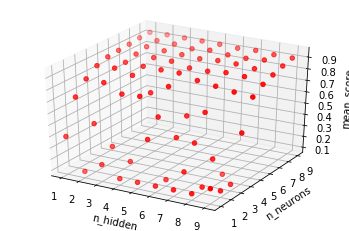

In [72]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.n_hidden, df.n_neurons, df.mean_test_score, c='r', marker='o')

ax.set_xlabel('n_hidden')
ax.set_ylabel('n_neurons')
ax.set_zlabel('mean_score')

plt.show()

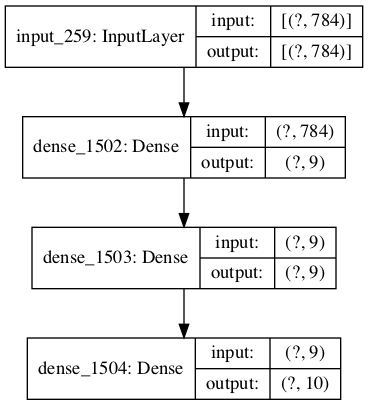

In [73]:
best_model = grid_cv3.best_estimator_.model
keras.utils.plot_model(best_model, show_shapes=True)

In [74]:
best_model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 19us/sample - loss: 0.2306 - accuracy: 0.9401


[0.23058634167909622, 0.9401]

In [75]:
best_model.summary() # on layer with 4 neurons

Model: "sequential_258"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1502 (Dense)           (None, 9)                 7065      
_________________________________________________________________
dense_1503 (Dense)           (None, 9)                 90        
_________________________________________________________________
dense_1504 (Dense)           (None, 10)                100       
Total params: 7,255
Trainable params: 7,255
Non-trainable params: 0
_________________________________________________________________
